In [240]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy.io as sio
from torch.autograd import Variable
import torch.nn.functional as F

In [250]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ResidualBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.activation1 = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride= 1, padding= 2)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.activation2 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride= 1, padding= 2)
    
    def forward(self,x):
        residual  = torch.clone(x)
        x = self.bn1(x)
        x = self.activation1(x)
        x = self.conv1(x)
        x = self.conv2(self.activation2(self.bn2(x)))
        residual = residual.unsqueeze(0)
        residual = nn.functional.interpolate(residual, size = [x.shape[1], x.shape[2], x.shape[3]])
        residual = residual.squeeze(0)
        x += residual
        return x
     
class ModelSubDep(nn.Module):

    def __init__(self):
        super(ModelSubDep, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 5, out_channels = 32, kernel_size= 5, stride= 1, padding= 2)
        self.resblock1 = ResidualBlock(32,32,5)
        self.resblock2 = ResidualBlock(32,64,5)
        self.resblock3 = ResidualBlock(64,128,5)
        self.avgpool = nn.AdaptiveAvgPool2d((15,15))
        self.linear1 = nn.Linear(15*15*128, 1024)
        self.drop1 = nn.Dropout(0.2)
        self.linear2 = nn.Linear(1024, 512)
        self.drop2 = nn.Dropout(0.2)


    def forward(self, x):
        x = self.conv1(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.avgpool(x)
        F = nn.Flatten()
        x = F(x)
        x = self.linear1(x)
        x = self.drop1(x)
        x = self.linear2(x)
        x = self.drop2(x)
        return x

class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.T = 384
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 32), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))

    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)

        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        # FC Layer
        x = x.reshape(-1, 4*2*24)
        return x

class combinedModel(nn.Module):
    def __init__(self):
        super(combinedModel, self).__init__()
        self.BCModel = ModelSubDep()
        self.EEGNet = EEGNet()
        self.fc1 = nn.Linear(704,2)
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self,x1,x2):
        out1 = self.BCModel(x1)
        out2 = self.EEGNet(x2)
        x = torch.cat((out1,out2),1)
        x = self.softmax(self.fc1(x))
        return x

In [251]:
import scipy
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold as skf

class Dataset(Dataset):
    def __init__(self, data1, data2, info):
        #data loading
        self.x = data1
        self.y = info
        self.w = data2
        self.n_samples = data1.shape[0]


    def __getitem__(self,index):
        t1 = self.x[index]
        t2 = self.y[index]
        t3 = self.w[index]
        t1 = torch.tensor(t1).permute((2,0,1))
        t2 = torch.tensor(t2)
        t3 = (torch.tensor(t3))
        return (t1,t3,t2)
    
    def __len__(self):
        return self.n_samples
    
# data = scipy.io.loadmat('/home/desktop/Desktop/22104412_Docs/EEG-COGMusic/Baseline/datasets/CSP_features_s01.mat')

In [252]:
data = scipy.io.loadmat('/home/desktop/Desktop/22104412_Docs/EEG-COGMusic/Baseline/datasets/s01_datasets_Zscore_clipped.mat')

In [253]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'coh', 'pli', 'psd', 'labels_kfold', 'valence', 'arousal', 'multiclass', 'EEGNet'])

In [254]:
x_c=data['coh']
x_p = data['pli']
x_d = data['psd']
labels_skf = data['labels_kfold']
labels = data['arousal']
data_EEGNet = data['EEGNet']

In [255]:
x_n = np.zeros((40,75,32,32,5))
for trial in range(x_n.shape[0]):
    for sample in range(x_n.shape[1]):
        x_n[trial,sample,:,:,0] = x_c[trial,sample,:,:,0]+np.transpose(x_p[trial,sample,:,:,0])
        x_n[trial,sample,:,:,1] = x_c[trial,sample,:,:,1]+np.transpose(x_p[trial,sample,:,:,1])
        x_n[trial,sample,:,:,2] = x_c[trial,sample,:,:,2]+np.transpose(x_p[trial,sample,:,:,2])
        x_n[trial,sample,:,:,3] = x_c[trial,sample,:,:,3]+np.transpose(x_p[trial,sample,:,:,3])
        x_n[trial,sample,:,:,4] = x_c[trial,sample,:,:,4]+np.transpose(x_p[trial,sample,:,:,4])
    print(f'Completed trial {trial}')

for trial in range(x_n.shape[0]):
    for sample in range(x_n.shape[1]):
        for i in range(32):
            x_n[trial,sample,i,i,:] = x_d[trial,sample,i,:]
    print(f'Completed trial {trial}')

Completed trial 0
Completed trial 1
Completed trial 2
Completed trial 3
Completed trial 4
Completed trial 5
Completed trial 6
Completed trial 7
Completed trial 8
Completed trial 9
Completed trial 10
Completed trial 11
Completed trial 12
Completed trial 13
Completed trial 14
Completed trial 15
Completed trial 16
Completed trial 17
Completed trial 18
Completed trial 19
Completed trial 20
Completed trial 21
Completed trial 22
Completed trial 23
Completed trial 24
Completed trial 25
Completed trial 26
Completed trial 27
Completed trial 28
Completed trial 29
Completed trial 30
Completed trial 31
Completed trial 32
Completed trial 33
Completed trial 34
Completed trial 35
Completed trial 36
Completed trial 37
Completed trial 38
Completed trial 39
Completed trial 0
Completed trial 1
Completed trial 2
Completed trial 3
Completed trial 4
Completed trial 5
Completed trial 6
Completed trial 7
Completed trial 8
Completed trial 9
Completed trial 10
Completed trial 11
Completed trial 12
Completed tri

In [256]:
model = combinedModel()

In [257]:
v = labels_skf[:,1]
indices = np.where((v>5.5)|(v<4.5))[0]

dt = x_n[indices]
labels = labels[indices]
trainLoss={}
valLoss = {}
trainAcc = {}
valAcc = {}

In [258]:
l_skf = np.zeros([40,1])
l_skf[np.where(labels_skf[:,1]>5)[0]] = 1
l_skf = l_skf[indices]
l_skf.shape

(39, 1)

In [259]:
de = data_EEGNet
de = de.transpose((0,1,3,2))
de = de[indices,:,np.newaxis,:,:]

In [260]:
de.shape

(39, 75, 1, 384, 32)

In [261]:
l_skf

array([[1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [262]:
kf = skf(n_splits = 10)
log_pred_dict = {}
for k,(train_index,test_index) in enumerate(kf.split(dt, l_skf)):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f'Fold {k+1} running')
    deTr, deV = np.concatenate(de[train_index],0), np.concatenate(de[test_index],0)
    dataTr, dataV = np.concatenate(dt[train_index],0), np.concatenate(dt[test_index],0)
    labelsTr, labelsV = np.concatenate(labels[train_index],0), np.concatenate(labels[test_index],0)
    tL = []
    vL = []
    tAV = []
    vAV = []
    y_train = np.argmax(labelsTr, axis=1)
    class_counts = np.bincount(y_train)
    num_classes = len(class_counts)
    total_samples = len(y_train)

    class_weights = []
    for count in class_counts:
        weight = 1 / (count / total_samples)
        class_weights.append(weight)
    
    weights = torch.tensor(np.array(class_weights))
    weights = weights.to(device)
    # testAC = []
    model = combinedModel()
    model = model.to(device)
     # Define your weights as a tensor
    criterion1 = nn.CrossEntropyLoss(weight=weights)
    optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum= 0.9)
    trainDS = Dataset(dataTr, deTr, labelsTr)
    trainDL = DataLoader(dataset = trainDS, batch_size = 100, shuffle = True)
    
    valDS = Dataset(dataV,deV,labelsV)
    valDL = DataLoader(dataset = valDS, batch_size = 100, shuffle = True)
    
    testDS = Dataset(dataV, deV, labelsV)
    testDL = DataLoader(dataset = testDS, batch_size = 100)
    
    num_epochs = 50
    batchsize = 100
    l2_lambda = 0.001
    best_va = 0
    for epoch in range(num_epochs):
        trainAccuracy = 0
        totalLoss = 0
        with tqdm(trainDL, unit='batch') as tepoch:
            model.train()
            for imagest,wavet,lab in tepoch:
                imagest = imagest.to(device)
                wavet = wavet.to(device)
                lab = lab.to(device)
                optimizer_ft.zero_grad()
                outputs = model(imagest.float(),wavet.float())
                _,predindex = torch.max(outputs, dim = 1)
                _,labindex = torch.max(lab, dim = 1)
                loss = criterion1(outputs,lab.float())
                l2_reg = 0.0
                for param in model.parameters():
                    l2_reg += torch.norm(param, p=2) # L2 norm of the parameter
                loss += l2_lambda * l2_reg
                loss.backward()
                optimizer_ft.step()
                totalLoss+=loss.item()
                acc = (predindex==labindex).sum().item()
                trainAccuracy += acc/(lab.shape[0]*len(trainDL))
                tepoch.set_postfix(loss=loss.item(),totalLoss =totalLoss/len(trainDL), TrainAccuracy= 100.*trainAccuracy)      
            model.eval()
            with torch.no_grad():
                  with tqdm(valDL, unit='batch') as tepoch:
                    total = 0
                    valAccuracy = 0
                    val_loss = 0
                    for imagesv,wavev,lab in tepoch:
                        imagesv = imagesv.to(device)
                        wavev = wavev.to(device)
                        labelsv = lab.to(device)
                        outval = model(imagesv.float(), wavev.float())
                        _,predindexval = torch.max(outval,dim = 1)
                        _,labvalindex = torch.max(labelsv,dim = 1)
                        acc = (predindexval == labvalindex).sum().item()
                        valAccuracy +=acc/(labelsv.shape[0]*len(valDL))
                        lossv = criterion1(outval,labelsv.float())
                        val_loss+= lossv.item()
                        tepoch.set_postfix(lossv=lossv.item(),valLoss =val_loss/len(valDL), ValAccuracy= 100.*valAccuracy)
        print('Epoch [{}], Loss_t: {:.4f},Loss_v: {:.4f}, train_acc:{:.4f}, val_acc:{:.4f}'.format(epoch, totalLoss/len(trainDL), val_loss/len(valDL),
                                                                                                100.*trainAccuracy,
                                                                                                100.*valAccuracy))
        tL.append(totalLoss/len(trainDL))
        vL.append(val_loss/len(valDL))
        tAV.append(100.*trainAccuracy)
        vAV.append( 100.*valAccuracy)
    trainLoss[str(k)] = tL
    valLoss[str(k)] = vL
    trainAcc[str(k)] = tAV
    valAcc[str(k)] = vAV
    model.eval()
    pt = []
    lt = []
    with torch.no_grad():
        with tqdm(testDL, unit='batch') as tepochtst:
            for imagestst,wavetst,labt in tepochtst:
                imagestst = imagestst.to(device)
                wavetst = wavetst.to(device)
                labelst = labt.to(device)
                outt = (model(imagestst.float(), wavetst.float()))
                _,predt = torch.max(outt,dim=1)
                _,labti = torch.max(labelst,dim =1)
                pt.append(predt)
                lt.append(labti)
    log_pred_dict[str(k)] = {'trails': test_index,
                             'predicted': pt,
                             'ground truth': lt}
tL = np.array(list(trainLoss.values()))
vL = np.array(list(valLoss.values()))
tAV = np.array(list(trainAcc.values()))
vAV = np.array(list(valAcc.values()))

Fold 1 running


100%|██████████| 3/3 [00:00<00:00, 25.03batch/s, ValAccuracy=48.3, lossv=1.25, valLoss=1.31]


Epoch [0], Loss_t: 1.5395,Loss_v: 1.3074, train_acc:46.4815, val_acc:48.3333


100%|██████████| 3/3 [00:00<00:00, 26.14batch/s, ValAccuracy=44.3, lossv=1.35, valLoss=1.34]


Epoch [1], Loss_t: 1.5323,Loss_v: 1.3353, train_acc:48.5556, val_acc:44.3333


100%|██████████| 3/3 [00:00<00:00, 21.55batch/s, ValAccuracy=51.7, lossv=1.33, valLoss=1.3]


Epoch [2], Loss_t: 1.5101,Loss_v: 1.3018, train_acc:50.6296, val_acc:51.6667


100%|██████████| 3/3 [00:00<00:00, 21.01batch/s, ValAccuracy=36.3, lossv=1.32, valLoss=1.36] 


Epoch [3], Loss_t: 1.5146,Loss_v: 1.3558, train_acc:52.8519, val_acc:36.3333


100%|██████████| 3/3 [00:00<00:00, 22.83batch/s, ValAccuracy=51.7, lossv=1.29, valLoss=1.31]


Epoch [4], Loss_t: 1.4986,Loss_v: 1.3147, train_acc:54.4074, val_acc:51.6667


100%|██████████| 3/3 [00:00<00:00, 20.60batch/s, ValAccuracy=47.7, lossv=1.3, valLoss=1.31]  


Epoch [5], Loss_t: 1.4962,Loss_v: 1.3096, train_acc:54.1852, val_acc:47.6667


100%|██████████| 3/3 [00:00<00:00, 21.39batch/s, ValAccuracy=46.3, lossv=1.31, valLoss=1.33]


Epoch [6], Loss_t: 1.4824,Loss_v: 1.3294, train_acc:57.1852, val_acc:46.3333


100%|██████████| 3/3 [00:00<00:00, 21.01batch/s, ValAccuracy=52.3, lossv=1.37, valLoss=1.33]


Epoch [7], Loss_t: 1.4813,Loss_v: 1.3279, train_acc:56.5926, val_acc:52.3333


100%|██████████| 3/3 [00:00<00:00, 22.42batch/s, ValAccuracy=55, lossv=1.29, valLoss=1.31]


Epoch [8], Loss_t: 1.4748,Loss_v: 1.3103, train_acc:56.6296, val_acc:55.0000


100%|██████████| 3/3 [00:00<00:00, 26.07batch/s, ValAccuracy=41.7, lossv=1.38, valLoss=1.37]


Epoch [9], Loss_t: 1.4675,Loss_v: 1.3666, train_acc:60.2222, val_acc:41.6667


100%|██████████| 3/3 [00:00<00:00, 26.61batch/s, ValAccuracy=52.3, lossv=1.36, valLoss=1.34]


Epoch [10], Loss_t: 1.4573,Loss_v: 1.3378, train_acc:59.7407, val_acc:52.3333


100%|██████████| 3/3 [00:00<00:00, 23.11batch/s, ValAccuracy=51.7, lossv=1.26, valLoss=1.32]


Epoch [11], Loss_t: 1.4543,Loss_v: 1.3236, train_acc:61.3333, val_acc:51.6667


100%|██████████| 3/3 [00:00<00:00, 21.90batch/s, ValAccuracy=49.7, lossv=1.31, valLoss=1.33]


Epoch [12], Loss_t: 1.4567,Loss_v: 1.3311, train_acc:60.6296, val_acc:49.6667


100%|██████████| 3/3 [00:00<00:00, 21.21batch/s, ValAccuracy=49, lossv=1.32, valLoss=1.34]


Epoch [13], Loss_t: 1.4430,Loss_v: 1.3383, train_acc:62.5556, val_acc:49.0000


100%|██████████| 3/3 [00:00<00:00, 21.27batch/s, ValAccuracy=46, lossv=1.33, valLoss=1.36]   


Epoch [14], Loss_t: 1.4434,Loss_v: 1.3638, train_acc:62.6296, val_acc:46.0000


100%|██████████| 3/3 [00:00<00:00, 21.23batch/s, ValAccuracy=50.3, lossv=1.35, valLoss=1.36]


Epoch [15], Loss_t: 1.4319,Loss_v: 1.3600, train_acc:63.7037, val_acc:50.3333


100%|██████████| 3/3 [00:00<00:00, 20.53batch/s, ValAccuracy=51, lossv=1.34, valLoss=1.35] 


Epoch [16], Loss_t: 1.4339,Loss_v: 1.3457, train_acc:62.3704, val_acc:51.0000


100%|██████████| 3/3 [00:00<00:00, 20.72batch/s, ValAccuracy=51.3, lossv=1.28, valLoss=1.34]


Epoch [17], Loss_t: 1.4247,Loss_v: 1.3393, train_acc:63.9630, val_acc:51.3333


100%|██████████| 3/3 [00:00<00:00, 20.98batch/s, ValAccuracy=48.3, lossv=1.33, valLoss=1.37] 


Epoch [18], Loss_t: 1.4278,Loss_v: 1.3671, train_acc:64.3704, val_acc:48.3333


100%|██████████| 3/3 [00:00<00:00, 20.60batch/s, ValAccuracy=49.7, lossv=1.28, valLoss=1.36] 


Epoch [19], Loss_t: 1.4306,Loss_v: 1.3597, train_acc:62.7778, val_acc:49.6667


100%|██████████| 3/3 [00:00<00:00, 23.18batch/s, ValAccuracy=49.3, lossv=1.39, valLoss=1.36]


Epoch [20], Loss_t: 1.4145,Loss_v: 1.3569, train_acc:64.4815, val_acc:49.3333


100%|██████████| 3/3 [00:00<00:00, 26.55batch/s, ValAccuracy=51, lossv=1.35, valLoss=1.34]


Epoch [21], Loss_t: 1.4127,Loss_v: 1.3413, train_acc:65.4074, val_acc:51.0000


100%|██████████| 3/3 [00:00<00:00, 25.65batch/s, ValAccuracy=51, lossv=1.33, valLoss=1.35]


Epoch [22], Loss_t: 1.4093,Loss_v: 1.3456, train_acc:64.5185, val_acc:51.0000


100%|██████████| 3/3 [00:00<00:00, 21.15batch/s, ValAccuracy=46.7, lossv=1.37, valLoss=1.37]


Epoch [23], Loss_t: 1.4176,Loss_v: 1.3732, train_acc:64.6667, val_acc:46.6667


100%|██████████| 3/3 [00:00<00:00, 22.56batch/s, ValAccuracy=45, lossv=1.38, valLoss=1.41]


Epoch [24], Loss_t: 1.4099,Loss_v: 1.4084, train_acc:65.1111, val_acc:45.0000


100%|██████████| 3/3 [00:00<00:00, 21.29batch/s, ValAccuracy=50.7, lossv=1.34, valLoss=1.34]


Epoch [25], Loss_t: 1.4032,Loss_v: 1.3394, train_acc:66.0000, val_acc:50.6667


100%|██████████| 3/3 [00:00<00:00, 19.74batch/s, ValAccuracy=61.3, lossv=1.28, valLoss=1.29]


Epoch [26], Loss_t: 1.4179,Loss_v: 1.2863, train_acc:63.8889, val_acc:61.3333


100%|██████████| 3/3 [00:00<00:00, 23.13batch/s, ValAccuracy=54, lossv=1.37, valLoss=1.33]


Epoch [27], Loss_t: 1.4039,Loss_v: 1.3316, train_acc:65.6667, val_acc:54.0000


100%|██████████| 3/3 [00:00<00:00, 20.67batch/s, ValAccuracy=43.3, lossv=1.45, valLoss=1.42]


Epoch [28], Loss_t: 1.3977,Loss_v: 1.4229, train_acc:66.7037, val_acc:43.3333


100%|██████████| 3/3 [00:00<00:00, 26.16batch/s, ValAccuracy=49.7, lossv=1.42, valLoss=1.35]


Epoch [29], Loss_t: 1.3929,Loss_v: 1.3507, train_acc:66.2963, val_acc:49.6667


100%|██████████| 3/3 [00:00<00:00, 25.18batch/s, ValAccuracy=56, lossv=1.33, valLoss=1.31]


Epoch [30], Loss_t: 1.3903,Loss_v: 1.3123, train_acc:66.2963, val_acc:56.0000


100%|██████████| 3/3 [00:00<00:00, 26.39batch/s, ValAccuracy=55.7, lossv=1.33, valLoss=1.3]


Epoch [31], Loss_t: 1.3866,Loss_v: 1.3034, train_acc:66.8519, val_acc:55.6667


100%|██████████| 3/3 [00:00<00:00, 26.48batch/s, ValAccuracy=49.3, lossv=1.43, valLoss=1.38]


Epoch [32], Loss_t: 1.3818,Loss_v: 1.3848, train_acc:66.8889, val_acc:49.3333


100%|██████████| 3/3 [00:00<00:00, 26.87batch/s, ValAccuracy=51.7, lossv=1.33, valLoss=1.34]


Epoch [33], Loss_t: 1.3755,Loss_v: 1.3383, train_acc:68.2222, val_acc:51.6667


100%|██████████| 3/3 [00:00<00:00, 27.20batch/s, ValAccuracy=53.7, lossv=1.31, valLoss=1.34]


Epoch [34], Loss_t: 1.3745,Loss_v: 1.3376, train_acc:67.4444, val_acc:53.6667


100%|██████████| 3/3 [00:00<00:00, 27.10batch/s, ValAccuracy=55.7, lossv=1.32, valLoss=1.33]


Epoch [35], Loss_t: 1.3712,Loss_v: 1.3349, train_acc:68.8519, val_acc:55.6667


100%|██████████| 3/3 [00:00<00:00, 26.69batch/s, ValAccuracy=54.3, lossv=1.34, valLoss=1.32]


Epoch [36], Loss_t: 1.3628,Loss_v: 1.3195, train_acc:68.7778, val_acc:54.3333


100%|██████████| 3/3 [00:00<00:00, 26.59batch/s, ValAccuracy=51.7, lossv=1.36, valLoss=1.35]


Epoch [37], Loss_t: 1.3683,Loss_v: 1.3525, train_acc:68.2222, val_acc:51.6667


100%|██████████| 3/3 [00:00<00:00, 26.84batch/s, ValAccuracy=55, lossv=1.32, valLoss=1.33]


Epoch [38], Loss_t: 1.3643,Loss_v: 1.3309, train_acc:67.4444, val_acc:55.0000


100%|██████████| 3/3 [00:00<00:00, 26.87batch/s, ValAccuracy=54.3, lossv=1.3, valLoss=1.3]


Epoch [39], Loss_t: 1.3530,Loss_v: 1.3030, train_acc:69.0000, val_acc:54.3333


100%|██████████| 3/3 [00:00<00:00, 21.08batch/s, ValAccuracy=54, lossv=1.37, valLoss=1.34]


Epoch [40], Loss_t: 1.3412,Loss_v: 1.3395, train_acc:70.3333, val_acc:54.0000


100%|██████████| 3/3 [00:00<00:00, 21.83batch/s, ValAccuracy=54, lossv=1.31, valLoss=1.33]


Epoch [41], Loss_t: 1.3429,Loss_v: 1.3329, train_acc:70.7037, val_acc:54.0000


100%|██████████| 3/3 [00:00<00:00, 21.26batch/s, ValAccuracy=55.7, lossv=1.3, valLoss=1.3]


Epoch [42], Loss_t: 1.3404,Loss_v: 1.3050, train_acc:69.7778, val_acc:55.6667


100%|██████████| 3/3 [00:00<00:00, 21.98batch/s, ValAccuracy=58, lossv=1.29, valLoss=1.3]


Epoch [43], Loss_t: 1.3325,Loss_v: 1.3000, train_acc:70.3333, val_acc:58.0000


100%|██████████| 3/3 [00:00<00:00, 23.96batch/s, ValAccuracy=55.7, lossv=1.26, valLoss=1.3]


Epoch [44], Loss_t: 1.3275,Loss_v: 1.3048, train_acc:71.5185, val_acc:55.6667


100%|██████████| 3/3 [00:00<00:00, 22.71batch/s, ValAccuracy=54.3, lossv=1.3, valLoss=1.31]


Epoch [45], Loss_t: 1.3260,Loss_v: 1.3124, train_acc:71.4074, val_acc:54.3333


100%|██████████| 3/3 [00:00<00:00, 26.81batch/s, ValAccuracy=54.3, lossv=1.37, valLoss=1.31]


Epoch [46], Loss_t: 1.3123,Loss_v: 1.3084, train_acc:73.3704, val_acc:54.3333


100%|██████████| 3/3 [00:00<00:00, 26.65batch/s, ValAccuracy=58, lossv=1.25, valLoss=1.27]


Epoch [47], Loss_t: 1.3134,Loss_v: 1.2725, train_acc:71.8519, val_acc:58.0000


100%|██████████| 3/3 [00:00<00:00, 26.77batch/s, ValAccuracy=54, lossv=1.29, valLoss=1.31]


Epoch [48], Loss_t: 1.3081,Loss_v: 1.3127, train_acc:72.2593, val_acc:54.0000


100%|██████████| 3/3 [00:00<00:00, 26.37batch/s, ValAccuracy=66, lossv=1.16, valLoss=1.22]


Epoch [49], Loss_t: 1.2966,Loss_v: 1.2174, train_acc:73.7778, val_acc:66.0000


100%|██████████| 3/3 [00:00<00:00, 40.80batch/s]


Fold 2 running


100%|██████████| 3/3 [00:00<00:00, 21.44batch/s, ValAccuracy=45.3, lossv=1.31, valLoss=1.32]


Epoch [0], Loss_t: 1.5230,Loss_v: 1.3200, train_acc:48.2593, val_acc:45.3333


100%|██████████| 3/3 [00:00<00:00, 22.09batch/s, ValAccuracy=42.3, lossv=1.33, valLoss=1.34]


Epoch [1], Loss_t: 1.5247,Loss_v: 1.3362, train_acc:49.2593, val_acc:42.3333


100%|██████████| 3/3 [00:00<00:00, 26.39batch/s, ValAccuracy=48.3, lossv=1.33, valLoss=1.32]


Epoch [2], Loss_t: 1.5036,Loss_v: 1.3197, train_acc:52.3333, val_acc:48.3333


100%|██████████| 3/3 [00:00<00:00, 20.94batch/s, ValAccuracy=47, lossv=1.38, valLoss=1.34]


Epoch [3], Loss_t: 1.4998,Loss_v: 1.3375, train_acc:53.0000, val_acc:47.0000


100%|██████████| 3/3 [00:00<00:00, 25.87batch/s, ValAccuracy=43.3, lossv=1.36, valLoss=1.35]


Epoch [4], Loss_t: 1.4882,Loss_v: 1.3473, train_acc:54.5185, val_acc:43.3333


100%|██████████| 3/3 [00:00<00:00, 22.96batch/s, ValAccuracy=45.7, lossv=1.32, valLoss=1.35]


Epoch [5], Loss_t: 1.4876,Loss_v: 1.3534, train_acc:56.1111, val_acc:45.6667


100%|██████████| 3/3 [00:00<00:00, 21.08batch/s, ValAccuracy=41, lossv=1.36, valLoss=1.37]


Epoch [6], Loss_t: 1.4767,Loss_v: 1.3674, train_acc:58.3333, val_acc:41.0000


100%|██████████| 3/3 [00:00<00:00, 23.56batch/s, ValAccuracy=46.7, lossv=1.38, valLoss=1.37]


Epoch [7], Loss_t: 1.4716,Loss_v: 1.3658, train_acc:56.5926, val_acc:46.6667


100%|██████████| 3/3 [00:00<00:00, 22.49batch/s, ValAccuracy=48, lossv=1.35, valLoss=1.37]


Epoch [8], Loss_t: 1.4636,Loss_v: 1.3674, train_acc:59.8519, val_acc:48.0000


100%|██████████| 3/3 [00:00<00:00, 20.92batch/s, ValAccuracy=50.7, lossv=1.33, valLoss=1.36]


Epoch [9], Loss_t: 1.4599,Loss_v: 1.3580, train_acc:59.8519, val_acc:50.6667


100%|██████████| 3/3 [00:00<00:00, 23.25batch/s, ValAccuracy=44.3, lossv=1.39, valLoss=1.39]


Epoch [10], Loss_t: 1.4585,Loss_v: 1.3943, train_acc:59.7037, val_acc:44.3333


100%|██████████| 3/3 [00:00<00:00, 21.95batch/s, ValAccuracy=48.3, lossv=1.44, valLoss=1.38]


Epoch [11], Loss_t: 1.4522,Loss_v: 1.3810, train_acc:61.9630, val_acc:48.3333


100%|██████████| 3/3 [00:00<00:00, 26.23batch/s, ValAccuracy=60, lossv=1.22, valLoss=1.32]


Epoch [12], Loss_t: 1.4440,Loss_v: 1.3159, train_acc:60.8148, val_acc:60.0000


100%|██████████| 3/3 [00:00<00:00, 26.74batch/s, ValAccuracy=52.3, lossv=1.37, valLoss=1.37]


Epoch [13], Loss_t: 1.4436,Loss_v: 1.3717, train_acc:62.2963, val_acc:52.3333


100%|██████████| 3/3 [00:00<00:00, 26.72batch/s, ValAccuracy=48.7, lossv=1.39, valLoss=1.39]


Epoch [14], Loss_t: 1.4424,Loss_v: 1.3875, train_acc:61.7778, val_acc:48.6667


100%|██████████| 3/3 [00:00<00:00, 21.39batch/s, ValAccuracy=48.3, lossv=1.51, valLoss=1.4]


Epoch [15], Loss_t: 1.4400,Loss_v: 1.4048, train_acc:62.0370, val_acc:48.3333


100%|██████████| 3/3 [00:00<00:00, 26.99batch/s, ValAccuracy=56, lossv=1.34, valLoss=1.36]


Epoch [16], Loss_t: 1.4367,Loss_v: 1.3637, train_acc:61.6667, val_acc:56.0000


100%|██████████| 3/3 [00:00<00:00, 21.08batch/s, ValAccuracy=53, lossv=1.36, valLoss=1.39]


Epoch [17], Loss_t: 1.4286,Loss_v: 1.3874, train_acc:62.7037, val_acc:53.0000


100%|██████████| 3/3 [00:00<00:00, 21.26batch/s, ValAccuracy=54.3, lossv=1.37, valLoss=1.38]


Epoch [18], Loss_t: 1.4291,Loss_v: 1.3836, train_acc:63.8148, val_acc:54.3333


100%|██████████| 3/3 [00:00<00:00, 26.87batch/s, ValAccuracy=55, lossv=1.41, valLoss=1.37]


Epoch [19], Loss_t: 1.4088,Loss_v: 1.3684, train_acc:65.7778, val_acc:55.0000


100%|██████████| 3/3 [00:00<00:00, 23.16batch/s, ValAccuracy=53.7, lossv=1.38, valLoss=1.39]


Epoch [20], Loss_t: 1.4057,Loss_v: 1.3910, train_acc:65.7037, val_acc:53.6667


100%|██████████| 3/3 [00:00<00:00, 20.83batch/s, ValAccuracy=53.3, lossv=1.43, valLoss=1.4] 


Epoch [21], Loss_t: 1.4132,Loss_v: 1.4039, train_acc:64.4074, val_acc:53.3333


100%|██████████| 3/3 [00:00<00:00, 23.09batch/s, ValAccuracy=52.3, lossv=1.32, valLoss=1.4]


Epoch [22], Loss_t: 1.4087,Loss_v: 1.3960, train_acc:66.0741, val_acc:52.3333


100%|██████████| 3/3 [00:00<00:00, 26.32batch/s, ValAccuracy=49.3, lossv=1.45, valLoss=1.41]


Epoch [23], Loss_t: 1.3986,Loss_v: 1.4068, train_acc:66.0370, val_acc:49.3333


100%|██████████| 3/3 [00:00<00:00, 26.33batch/s, ValAccuracy=52.7, lossv=1.46, valLoss=1.42]


Epoch [24], Loss_t: 1.3940,Loss_v: 1.4173, train_acc:65.8889, val_acc:52.6667


100%|██████████| 3/3 [00:00<00:00, 26.20batch/s, ValAccuracy=55.7, lossv=1.39, valLoss=1.38]


Epoch [25], Loss_t: 1.3921,Loss_v: 1.3833, train_acc:66.7037, val_acc:55.6667


100%|██████████| 3/3 [00:00<00:00, 22.07batch/s, ValAccuracy=56.3, lossv=1.44, valLoss=1.39]


Epoch [26], Loss_t: 1.3936,Loss_v: 1.3878, train_acc:66.0370, val_acc:56.3333


100%|██████████| 3/3 [00:00<00:00, 22.99batch/s, ValAccuracy=58.3, lossv=1.4, valLoss=1.39]


Epoch [27], Loss_t: 1.3945,Loss_v: 1.3902, train_acc:65.9630, val_acc:58.3333


100%|██████████| 3/3 [00:00<00:00, 26.13batch/s, ValAccuracy=57.7, lossv=1.26, valLoss=1.37]


Epoch [28], Loss_t: 1.3868,Loss_v: 1.3749, train_acc:66.1481, val_acc:57.6667


100%|██████████| 3/3 [00:00<00:00, 26.52batch/s, ValAccuracy=54, lossv=1.4, valLoss=1.38]


Epoch [29], Loss_t: 1.3742,Loss_v: 1.3841, train_acc:67.5185, val_acc:54.0000


100%|██████████| 3/3 [00:00<00:00, 26.15batch/s, ValAccuracy=47.3, lossv=1.44, valLoss=1.44]


Epoch [30], Loss_t: 1.3726,Loss_v: 1.4390, train_acc:68.2963, val_acc:47.3333


100%|██████████| 3/3 [00:00<00:00, 26.43batch/s, ValAccuracy=55, lossv=1.42, valLoss=1.4]


Epoch [31], Loss_t: 1.3689,Loss_v: 1.4019, train_acc:68.0370, val_acc:55.0000


100%|██████████| 3/3 [00:00<00:00, 23.83batch/s, ValAccuracy=58.3, lossv=1.42, valLoss=1.37]


Epoch [32], Loss_t: 1.3617,Loss_v: 1.3653, train_acc:67.8519, val_acc:58.3333


100%|██████████| 3/3 [00:00<00:00, 20.76batch/s, ValAccuracy=57.3, lossv=1.35, valLoss=1.36]


Epoch [33], Loss_t: 1.3581,Loss_v: 1.3599, train_acc:69.2593, val_acc:57.3333


100%|██████████| 3/3 [00:00<00:00, 21.48batch/s, ValAccuracy=55.7, lossv=1.33, valLoss=1.38]


Epoch [34], Loss_t: 1.3512,Loss_v: 1.3795, train_acc:70.0741, val_acc:55.6667


100%|██████████| 3/3 [00:00<00:00, 21.56batch/s, ValAccuracy=52.3, lossv=1.32, valLoss=1.38]


Epoch [35], Loss_t: 1.3460,Loss_v: 1.3838, train_acc:69.9630, val_acc:52.3333


100%|██████████| 3/3 [00:00<00:00, 21.02batch/s, ValAccuracy=56.3, lossv=1.41, valLoss=1.36]


Epoch [36], Loss_t: 1.3384,Loss_v: 1.3633, train_acc:70.8148, val_acc:56.3333


100%|██████████| 3/3 [00:00<00:00, 21.26batch/s, ValAccuracy=56.3, lossv=1.35, valLoss=1.35]


Epoch [37], Loss_t: 1.3349,Loss_v: 1.3460, train_acc:71.0741, val_acc:56.3333


100%|██████████| 3/3 [00:00<00:00, 21.15batch/s, ValAccuracy=54.3, lossv=1.4, valLoss=1.36]  


Epoch [38], Loss_t: 1.3310,Loss_v: 1.3560, train_acc:70.5556, val_acc:54.3333


100%|██████████| 3/3 [00:00<00:00, 21.20batch/s, ValAccuracy=52.3, lossv=1.34, valLoss=1.36]


Epoch [39], Loss_t: 1.3221,Loss_v: 1.3612, train_acc:71.8889, val_acc:52.3333


100%|██████████| 3/3 [00:00<00:00, 22.12batch/s, ValAccuracy=49, lossv=1.41, valLoss=1.39]


Epoch [40], Loss_t: 1.3098,Loss_v: 1.3935, train_acc:72.9259, val_acc:49.0000


100%|██████████| 3/3 [00:00<00:00, 22.29batch/s, ValAccuracy=53, lossv=1.37, valLoss=1.38]


Epoch [41], Loss_t: 1.3100,Loss_v: 1.3789, train_acc:72.5556, val_acc:53.0000


100%|██████████| 3/3 [00:00<00:00, 21.77batch/s, ValAccuracy=55, lossv=1.31, valLoss=1.34]


Epoch [42], Loss_t: 1.3079,Loss_v: 1.3436, train_acc:71.8148, val_acc:55.0000


100%|██████████| 3/3 [00:00<00:00, 20.79batch/s, ValAccuracy=47.3, lossv=1.44, valLoss=1.37] 


Epoch [43], Loss_t: 1.2928,Loss_v: 1.3741, train_acc:73.7778, val_acc:47.3333


100%|██████████| 3/3 [00:00<00:00, 24.17batch/s, ValAccuracy=50, lossv=1.43, valLoss=1.39]


Epoch [44], Loss_t: 1.2958,Loss_v: 1.3860, train_acc:72.2593, val_acc:50.0000


100%|██████████| 3/3 [00:00<00:00, 25.76batch/s, ValAccuracy=58.3, lossv=1.45, valLoss=1.32]


Epoch [45], Loss_t: 1.2842,Loss_v: 1.3229, train_acc:73.3704, val_acc:58.3333


100%|██████████| 3/3 [00:00<00:00, 26.37batch/s, ValAccuracy=59.7, lossv=1.34, valLoss=1.3]


Epoch [46], Loss_t: 1.2759,Loss_v: 1.3019, train_acc:73.4074, val_acc:59.6667


100%|██████████| 3/3 [00:00<00:00, 25.79batch/s, ValAccuracy=57.3, lossv=1.39, valLoss=1.33]


Epoch [47], Loss_t: 1.2740,Loss_v: 1.3267, train_acc:74.2222, val_acc:57.3333


100%|██████████| 3/3 [00:00<00:00, 26.35batch/s, ValAccuracy=50, lossv=1.37, valLoss=1.37]


Epoch [48], Loss_t: 1.2699,Loss_v: 1.3704, train_acc:73.5556, val_acc:50.0000


100%|██████████| 3/3 [00:00<00:00, 22.17batch/s, ValAccuracy=56.3, lossv=1.34, valLoss=1.33]


Epoch [49], Loss_t: 1.2623,Loss_v: 1.3349, train_acc:74.3333, val_acc:56.3333


100%|██████████| 3/3 [00:00<00:00, 42.01batch/s]


Fold 3 running


100%|██████████| 3/3 [00:00<00:00, 22.56batch/s, ValAccuracy=52, lossv=1.28, valLoss=1.3]


Epoch [0], Loss_t: 1.5281,Loss_v: 1.2969, train_acc:47.0741, val_acc:52.0000


100%|██████████| 3/3 [00:00<00:00, 26.08batch/s, ValAccuracy=62.7, lossv=1.2, valLoss=1.27]


Epoch [1], Loss_t: 1.5137,Loss_v: 1.2696, train_acc:49.3333, val_acc:62.6667


100%|██████████| 3/3 [00:00<00:00, 24.79batch/s, ValAccuracy=41.3, lossv=1.35, valLoss=1.34]


Epoch [2], Loss_t: 1.5080,Loss_v: 1.3429, train_acc:53.3704, val_acc:41.3333


100%|██████████| 3/3 [00:00<00:00, 26.39batch/s, ValAccuracy=66, lossv=1.3, valLoss=1.26]


Epoch [3], Loss_t: 1.5010,Loss_v: 1.2619, train_acc:52.1111, val_acc:66.0000


100%|██████████| 3/3 [00:00<00:00, 24.67batch/s, ValAccuracy=57.7, lossv=1.3, valLoss=1.28]


Epoch [4], Loss_t: 1.5000,Loss_v: 1.2823, train_acc:53.4815, val_acc:57.6667


100%|██████████| 3/3 [00:00<00:00, 21.78batch/s, ValAccuracy=36.3, lossv=1.36, valLoss=1.35]


Epoch [5], Loss_t: 1.4901,Loss_v: 1.3545, train_acc:58.1111, val_acc:36.3333


100%|██████████| 3/3 [00:00<00:00, 21.67batch/s, ValAccuracy=51, lossv=1.3, valLoss=1.3]


Epoch [6], Loss_t: 1.4853,Loss_v: 1.2996, train_acc:57.0370, val_acc:51.0000


100%|██████████| 3/3 [00:00<00:00, 24.57batch/s, ValAccuracy=64.7, lossv=1.23, valLoss=1.24]


Epoch [7], Loss_t: 1.4712,Loss_v: 1.2425, train_acc:56.6667, val_acc:64.6667


100%|██████████| 3/3 [00:00<00:00, 26.12batch/s, ValAccuracy=47, lossv=1.33, valLoss=1.32]


Epoch [8], Loss_t: 1.4748,Loss_v: 1.3235, train_acc:59.9630, val_acc:47.0000


100%|██████████| 3/3 [00:00<00:00, 26.68batch/s, ValAccuracy=45, lossv=1.32, valLoss=1.32]


Epoch [9], Loss_t: 1.4735,Loss_v: 1.3230, train_acc:57.8148, val_acc:45.0000


100%|██████████| 3/3 [00:00<00:00, 21.44batch/s, ValAccuracy=52.3, lossv=1.31, valLoss=1.28]


Epoch [10], Loss_t: 1.4666,Loss_v: 1.2840, train_acc:60.4074, val_acc:52.3333


100%|██████████| 3/3 [00:00<00:00, 22.36batch/s, ValAccuracy=61.7, lossv=1.27, valLoss=1.26]


Epoch [11], Loss_t: 1.4666,Loss_v: 1.2615, train_acc:59.7407, val_acc:61.6667


100%|██████████| 3/3 [00:00<00:00, 21.46batch/s, ValAccuracy=60.7, lossv=1.25, valLoss=1.26]


Epoch [12], Loss_t: 1.4574,Loss_v: 1.2619, train_acc:62.1481, val_acc:60.6667


100%|██████████| 3/3 [00:00<00:00, 26.71batch/s, ValAccuracy=54, lossv=1.31, valLoss=1.29]


Epoch [13], Loss_t: 1.4522,Loss_v: 1.2878, train_acc:61.7037, val_acc:54.0000


100%|██████████| 3/3 [00:00<00:00, 25.84batch/s, ValAccuracy=57, lossv=1.27, valLoss=1.27]


Epoch [14], Loss_t: 1.4443,Loss_v: 1.2741, train_acc:62.8889, val_acc:57.0000


100%|██████████| 3/3 [00:00<00:00, 22.83batch/s, ValAccuracy=49.3, lossv=1.33, valLoss=1.31]


Epoch [15], Loss_t: 1.4492,Loss_v: 1.3080, train_acc:62.9630, val_acc:49.3333


100%|██████████| 3/3 [00:00<00:00, 21.66batch/s, ValAccuracy=54, lossv=1.3, valLoss=1.28]


Epoch [16], Loss_t: 1.4478,Loss_v: 1.2797, train_acc:61.2593, val_acc:54.0000


100%|██████████| 3/3 [00:00<00:00, 22.35batch/s, ValAccuracy=63.7, lossv=1.19, valLoss=1.22]


Epoch [17], Loss_t: 1.4403,Loss_v: 1.2194, train_acc:62.0370, val_acc:63.6667


100%|██████████| 3/3 [00:00<00:00, 26.50batch/s, ValAccuracy=63.3, lossv=1.24, valLoss=1.23]


Epoch [18], Loss_t: 1.4336,Loss_v: 1.2296, train_acc:63.2963, val_acc:63.3333


100%|██████████| 3/3 [00:00<00:00, 26.58batch/s, ValAccuracy=54.7, lossv=1.25, valLoss=1.28]


Epoch [19], Loss_t: 1.4338,Loss_v: 1.2795, train_acc:63.8889, val_acc:54.6667


100%|██████████| 3/3 [00:00<00:00, 21.43batch/s, ValAccuracy=64.7, lossv=1.18, valLoss=1.21]


Epoch [20], Loss_t: 1.4321,Loss_v: 1.2133, train_acc:64.4074, val_acc:64.6667


100%|██████████| 3/3 [00:00<00:00, 24.25batch/s, ValAccuracy=62.7, lossv=1.21, valLoss=1.23]


Epoch [21], Loss_t: 1.4271,Loss_v: 1.2280, train_acc:63.8889, val_acc:62.6667


100%|██████████| 3/3 [00:00<00:00, 22.19batch/s, ValAccuracy=67.7, lossv=1.24, valLoss=1.21]


Epoch [22], Loss_t: 1.4417,Loss_v: 1.2129, train_acc:63.0000, val_acc:67.6667


100%|██████████| 3/3 [00:00<00:00, 26.67batch/s, ValAccuracy=64.7, lossv=1.25, valLoss=1.21]


Epoch [23], Loss_t: 1.4285,Loss_v: 1.2100, train_acc:64.0370, val_acc:64.6667


100%|██████████| 3/3 [00:00<00:00, 26.56batch/s, ValAccuracy=74.7, lossv=1.15, valLoss=1.16]


Epoch [24], Loss_t: 1.4238,Loss_v: 1.1560, train_acc:63.6296, val_acc:74.6667


100%|██████████| 3/3 [00:00<00:00, 26.63batch/s, ValAccuracy=73.7, lossv=1.13, valLoss=1.16]


Epoch [25], Loss_t: 1.4207,Loss_v: 1.1585, train_acc:63.0741, val_acc:73.6667


100%|██████████| 3/3 [00:00<00:00, 21.31batch/s, ValAccuracy=69.7, lossv=1.17, valLoss=1.19]


Epoch [26], Loss_t: 1.4303,Loss_v: 1.1851, train_acc:62.5926, val_acc:69.6667


100%|██████████| 3/3 [00:00<00:00, 21.65batch/s, ValAccuracy=55.3, lossv=1.26, valLoss=1.28]


Epoch [27], Loss_t: 1.4163,Loss_v: 1.2759, train_acc:64.8148, val_acc:55.3333


100%|██████████| 3/3 [00:00<00:00, 21.76batch/s, ValAccuracy=55, lossv=1.24, valLoss=1.27]


Epoch [28], Loss_t: 1.4163,Loss_v: 1.2727, train_acc:64.5926, val_acc:55.0000


100%|██████████| 3/3 [00:00<00:00, 20.92batch/s, ValAccuracy=68, lossv=1.17, valLoss=1.21]


Epoch [29], Loss_t: 1.4090,Loss_v: 1.2070, train_acc:65.3704, val_acc:68.0000


100%|██████████| 3/3 [00:00<00:00, 23.20batch/s, ValAccuracy=65, lossv=1.23, valLoss=1.21]


Epoch [30], Loss_t: 1.4023,Loss_v: 1.2074, train_acc:65.8148, val_acc:65.0000


100%|██████████| 3/3 [00:00<00:00, 22.28batch/s, ValAccuracy=70.7, lossv=1.11, valLoss=1.18]


Epoch [31], Loss_t: 1.4066,Loss_v: 1.1781, train_acc:65.3333, val_acc:70.6667


100%|██████████| 3/3 [00:00<00:00, 26.12batch/s, ValAccuracy=64.7, lossv=1.15, valLoss=1.21]


Epoch [32], Loss_t: 1.4058,Loss_v: 1.2122, train_acc:65.7778, val_acc:64.6667


100%|██████████| 3/3 [00:00<00:00, 26.54batch/s, ValAccuracy=73.3, lossv=1.16, valLoss=1.16]


Epoch [33], Loss_t: 1.3969,Loss_v: 1.1639, train_acc:66.1481, val_acc:73.3333


100%|██████████| 3/3 [00:00<00:00, 26.50batch/s, ValAccuracy=69.7, lossv=1.16, valLoss=1.18]


Epoch [34], Loss_t: 1.3900,Loss_v: 1.1790, train_acc:67.7037, val_acc:69.6667


100%|██████████| 3/3 [00:00<00:00, 19.52batch/s, ValAccuracy=60, lossv=1.26, valLoss=1.25] 


Epoch [35], Loss_t: 1.3821,Loss_v: 1.2460, train_acc:68.1111, val_acc:60.0000


100%|██████████| 3/3 [00:00<00:00, 20.95batch/s, ValAccuracy=65.7, lossv=1.24, valLoss=1.22] 


Epoch [36], Loss_t: 1.3889,Loss_v: 1.2156, train_acc:67.1852, val_acc:65.6667


100%|██████████| 3/3 [00:00<00:00, 21.86batch/s, ValAccuracy=68.3, lossv=1.18, valLoss=1.19]


Epoch [37], Loss_t: 1.3889,Loss_v: 1.1875, train_acc:66.8889, val_acc:68.3333


100%|██████████| 3/3 [00:00<00:00, 26.22batch/s, ValAccuracy=68.3, lossv=1.2, valLoss=1.19]


Epoch [38], Loss_t: 1.3739,Loss_v: 1.1856, train_acc:68.4815, val_acc:68.3333


100%|██████████| 3/3 [00:00<00:00, 20.86batch/s, ValAccuracy=67.7, lossv=1.18, valLoss=1.19]


Epoch [39], Loss_t: 1.3696,Loss_v: 1.1914, train_acc:68.8519, val_acc:67.6667


100%|██████████| 3/3 [00:00<00:00, 25.80batch/s, ValAccuracy=65.7, lossv=1.19, valLoss=1.22]


Epoch [40], Loss_t: 1.3703,Loss_v: 1.2202, train_acc:69.4444, val_acc:65.6667


100%|██████████| 3/3 [00:00<00:00, 26.38batch/s, ValAccuracy=63, lossv=1.28, valLoss=1.22]


Epoch [41], Loss_t: 1.3614,Loss_v: 1.2241, train_acc:69.9259, val_acc:63.0000


100%|██████████| 3/3 [00:00<00:00, 26.51batch/s, ValAccuracy=70.3, lossv=1.19, valLoss=1.17]


Epoch [42], Loss_t: 1.3537,Loss_v: 1.1731, train_acc:70.5556, val_acc:70.3333


100%|██████████| 3/3 [00:00<00:00, 26.82batch/s, ValAccuracy=73.7, lossv=1.15, valLoss=1.16]


Epoch [43], Loss_t: 1.3610,Loss_v: 1.1561, train_acc:69.7037, val_acc:73.6667


100%|██████████| 3/3 [00:00<00:00, 22.61batch/s, ValAccuracy=70.7, lossv=1.18, valLoss=1.16]


Epoch [44], Loss_t: 1.3548,Loss_v: 1.1624, train_acc:70.1852, val_acc:70.6667


100%|██████████| 3/3 [00:00<00:00, 25.33batch/s, ValAccuracy=75.7, lossv=1.2, valLoss=1.12]


Epoch [45], Loss_t: 1.3437,Loss_v: 1.1234, train_acc:70.0370, val_acc:75.6667


100%|██████████| 3/3 [00:00<00:00, 25.63batch/s, ValAccuracy=73.7, lossv=1.23, valLoss=1.15]


Epoch [46], Loss_t: 1.3391,Loss_v: 1.1516, train_acc:71.5556, val_acc:73.6667


100%|██████████| 3/3 [00:00<00:00, 25.89batch/s, ValAccuracy=72, lossv=1.17, valLoss=1.16]


Epoch [47], Loss_t: 1.3285,Loss_v: 1.1630, train_acc:71.6296, val_acc:72.0000


100%|██████████| 3/3 [00:00<00:00, 20.65batch/s, ValAccuracy=74.7, lossv=1.19, valLoss=1.14]


Epoch [48], Loss_t: 1.3214,Loss_v: 1.1390, train_acc:72.2222, val_acc:74.6667


100%|██████████| 3/3 [00:00<00:00, 21.39batch/s, ValAccuracy=69.7, lossv=1.21, valLoss=1.16]


Epoch [49], Loss_t: 1.3187,Loss_v: 1.1630, train_acc:72.6667, val_acc:69.6667


100%|██████████| 3/3 [00:00<00:00, 45.12batch/s]


Fold 4 running


100%|██████████| 3/3 [00:00<00:00, 26.26batch/s, ValAccuracy=50, lossv=1.32, valLoss=1.3]


Epoch [0], Loss_t: 1.5347,Loss_v: 1.3000, train_acc:48.3333, val_acc:50.0000


100%|██████████| 3/3 [00:00<00:00, 26.09batch/s, ValAccuracy=58.7, lossv=1.3, valLoss=1.28]


Epoch [1], Loss_t: 1.5230,Loss_v: 1.2773, train_acc:48.6296, val_acc:58.6667


100%|██████████| 3/3 [00:00<00:00, 23.41batch/s, ValAccuracy=55.7, lossv=1.31, valLoss=1.29]


Epoch [2], Loss_t: 1.5207,Loss_v: 1.2883, train_acc:50.7407, val_acc:55.6667


100%|██████████| 3/3 [00:00<00:00, 20.78batch/s, ValAccuracy=49.3, lossv=1.3, valLoss=1.29]


Epoch [3], Loss_t: 1.5151,Loss_v: 1.2925, train_acc:49.8519, val_acc:49.3333


100%|██████████| 3/3 [00:00<00:00, 24.44batch/s, ValAccuracy=53.7, lossv=1.31, valLoss=1.29]


Epoch [4], Loss_t: 1.5190,Loss_v: 1.2914, train_acc:51.7407, val_acc:53.6667


100%|██████████| 3/3 [00:00<00:00, 26.68batch/s, ValAccuracy=48.7, lossv=1.27, valLoss=1.3]


Epoch [5], Loss_t: 1.5082,Loss_v: 1.3049, train_acc:51.5926, val_acc:48.6667


100%|██████████| 3/3 [00:00<00:00, 26.78batch/s, ValAccuracy=68.7, lossv=1.21, valLoss=1.24]


Epoch [6], Loss_t: 1.5048,Loss_v: 1.2371, train_acc:52.5556, val_acc:68.6667


100%|██████████| 3/3 [00:00<00:00, 21.42batch/s, ValAccuracy=64.3, lossv=1.25, valLoss=1.24]


Epoch [7], Loss_t: 1.4950,Loss_v: 1.2427, train_acc:53.2593, val_acc:64.3333


100%|██████████| 3/3 [00:00<00:00, 22.11batch/s, ValAccuracy=64, lossv=1.25, valLoss=1.24]


Epoch [8], Loss_t: 1.4959,Loss_v: 1.2411, train_acc:54.8889, val_acc:64.0000


100%|██████████| 3/3 [00:00<00:00, 22.89batch/s, ValAccuracy=61.3, lossv=1.27, valLoss=1.25]


Epoch [9], Loss_t: 1.4917,Loss_v: 1.2528, train_acc:55.4815, val_acc:61.3333


100%|██████████| 3/3 [00:00<00:00, 22.93batch/s, ValAccuracy=55.7, lossv=1.27, valLoss=1.26]


Epoch [10], Loss_t: 1.4876,Loss_v: 1.2634, train_acc:56.1111, val_acc:55.6667


100%|██████████| 3/3 [00:00<00:00, 23.50batch/s, ValAccuracy=58.7, lossv=1.21, valLoss=1.25]


Epoch [11], Loss_t: 1.4830,Loss_v: 1.2489, train_acc:56.5185, val_acc:58.6667


100%|██████████| 3/3 [00:00<00:00, 20.64batch/s, ValAccuracy=73.3, lossv=1.16, valLoss=1.19] 


Epoch [12], Loss_t: 1.4743,Loss_v: 1.1919, train_acc:57.3333, val_acc:73.3333


100%|██████████| 3/3 [00:00<00:00, 21.03batch/s, ValAccuracy=77.7, lossv=1.15, valLoss=1.17] 


Epoch [13], Loss_t: 1.4790,Loss_v: 1.1690, train_acc:56.5556, val_acc:77.6667


100%|██████████| 3/3 [00:00<00:00, 20.83batch/s, ValAccuracy=70, lossv=1.21, valLoss=1.2] 


Epoch [14], Loss_t: 1.4691,Loss_v: 1.1995, train_acc:60.4444, val_acc:70.0000


100%|██████████| 3/3 [00:00<00:00, 21.39batch/s, ValAccuracy=68.7, lossv=1.19, valLoss=1.2]


Epoch [15], Loss_t: 1.4590,Loss_v: 1.1994, train_acc:61.1111, val_acc:68.6667


100%|██████████| 3/3 [00:00<00:00, 26.58batch/s, ValAccuracy=71, lossv=1.18, valLoss=1.19]


Epoch [16], Loss_t: 1.4578,Loss_v: 1.1941, train_acc:60.9630, val_acc:71.0000


100%|██████████| 3/3 [00:00<00:00, 20.70batch/s, ValAccuracy=71, lossv=1.19, valLoss=1.19]  


Epoch [17], Loss_t: 1.4630,Loss_v: 1.1867, train_acc:60.4074, val_acc:71.0000


100%|██████████| 3/3 [00:00<00:00, 26.06batch/s, ValAccuracy=72, lossv=1.18, valLoss=1.18]


Epoch [18], Loss_t: 1.4483,Loss_v: 1.1763, train_acc:61.6296, val_acc:72.0000


100%|██████████| 3/3 [00:00<00:00, 26.30batch/s, ValAccuracy=79.7, lossv=1.14, valLoss=1.14]


Epoch [19], Loss_t: 1.4421,Loss_v: 1.1426, train_acc:63.4444, val_acc:79.6667


100%|██████████| 3/3 [00:00<00:00, 26.74batch/s, ValAccuracy=66, lossv=1.22, valLoss=1.2]


Epoch [20], Loss_t: 1.4507,Loss_v: 1.1961, train_acc:61.8519, val_acc:66.0000


100%|██████████| 3/3 [00:00<00:00, 26.34batch/s, ValAccuracy=66.3, lossv=1.17, valLoss=1.18]


Epoch [21], Loss_t: 1.4411,Loss_v: 1.1754, train_acc:64.2222, val_acc:66.3333


100%|██████████| 3/3 [00:00<00:00, 20.79batch/s, ValAccuracy=80.3, lossv=1.13, valLoss=1.1]  


Epoch [22], Loss_t: 1.4251,Loss_v: 1.0957, train_acc:63.8889, val_acc:80.3333


100%|██████████| 3/3 [00:00<00:00, 20.47batch/s, ValAccuracy=75.7, lossv=1.12, valLoss=1.14] 


Epoch [23], Loss_t: 1.4284,Loss_v: 1.1415, train_acc:65.5556, val_acc:75.6667


100%|██████████| 3/3 [00:00<00:00, 20.69batch/s, ValAccuracy=81.3, lossv=1.09, valLoss=1.1]


Epoch [24], Loss_t: 1.4192,Loss_v: 1.1047, train_acc:64.5926, val_acc:81.3333


100%|██████████| 3/3 [00:00<00:00, 24.16batch/s, ValAccuracy=79, lossv=1.06, valLoss=1.11]


Epoch [25], Loss_t: 1.4210,Loss_v: 1.1114, train_acc:65.0000, val_acc:79.0000


100%|██████████| 3/3 [00:00<00:00, 20.37batch/s, ValAccuracy=73, lossv=1.12, valLoss=1.12]   


Epoch [26], Loss_t: 1.4080,Loss_v: 1.1151, train_acc:65.8519, val_acc:73.0000


100%|██████████| 3/3 [00:00<00:00, 20.96batch/s, ValAccuracy=70, lossv=1.14, valLoss=1.14]   


Epoch [27], Loss_t: 1.4007,Loss_v: 1.1377, train_acc:66.5185, val_acc:70.0000


100%|██████████| 3/3 [00:00<00:00, 25.98batch/s, ValAccuracy=76.7, lossv=1.15, valLoss=1.09]


Epoch [28], Loss_t: 1.3943,Loss_v: 1.0924, train_acc:66.8889, val_acc:76.6667


100%|██████████| 3/3 [00:00<00:00, 26.54batch/s, ValAccuracy=77.7, lossv=1.1, valLoss=1.09]


Epoch [29], Loss_t: 1.3866,Loss_v: 1.0857, train_acc:66.8148, val_acc:77.6667


100%|██████████| 3/3 [00:00<00:00, 21.37batch/s, ValAccuracy=76.7, lossv=1.06, valLoss=1.08]


Epoch [30], Loss_t: 1.3760,Loss_v: 1.0795, train_acc:67.9630, val_acc:76.6667


100%|██████████| 3/3 [00:00<00:00, 21.75batch/s, ValAccuracy=78.3, lossv=1.02, valLoss=1.08]


Epoch [31], Loss_t: 1.3677,Loss_v: 1.0782, train_acc:67.7778, val_acc:78.3333


100%|██████████| 3/3 [00:00<00:00, 20.05batch/s, ValAccuracy=78.3, lossv=1.06, valLoss=1.06] 


Epoch [32], Loss_t: 1.3713,Loss_v: 1.0589, train_acc:67.9630, val_acc:78.3333


100%|██████████| 3/3 [00:00<00:00, 26.61batch/s, ValAccuracy=68.3, lossv=1.15, valLoss=1.12]


Epoch [33], Loss_t: 1.3564,Loss_v: 1.1179, train_acc:69.1111, val_acc:68.3333


100%|██████████| 3/3 [00:00<00:00, 21.57batch/s, ValAccuracy=69.3, lossv=1.14, valLoss=1.1]


Epoch [34], Loss_t: 1.3539,Loss_v: 1.1020, train_acc:67.7778, val_acc:69.3333


100%|██████████| 3/3 [00:00<00:00, 20.91batch/s, ValAccuracy=74.3, lossv=1, valLoss=1.07]    


Epoch [35], Loss_t: 1.3400,Loss_v: 1.0683, train_acc:68.8519, val_acc:74.3333


100%|██████████| 3/3 [00:00<00:00, 20.92batch/s, ValAccuracy=73.3, lossv=1.07, valLoss=1.08] 


Epoch [36], Loss_t: 1.3457,Loss_v: 1.0814, train_acc:68.9259, val_acc:73.3333


100%|██████████| 3/3 [00:00<00:00, 22.15batch/s, ValAccuracy=71, lossv=1.08, valLoss=1.09]


Epoch [37], Loss_t: 1.3316,Loss_v: 1.0905, train_acc:69.2593, val_acc:71.0000


100%|██████████| 3/3 [00:00<00:00, 26.27batch/s, ValAccuracy=79, lossv=0.997, valLoss=1.05]


Epoch [38], Loss_t: 1.3302,Loss_v: 1.0535, train_acc:68.6296, val_acc:79.0000


100%|██████████| 3/3 [00:00<00:00, 26.27batch/s, ValAccuracy=71.7, lossv=1.05, valLoss=1.1]


Epoch [39], Loss_t: 1.3399,Loss_v: 1.0993, train_acc:69.8148, val_acc:71.6667


100%|██████████| 3/3 [00:00<00:00, 21.22batch/s, ValAccuracy=74.3, lossv=1.06, valLoss=1.07]


Epoch [40], Loss_t: 1.3226,Loss_v: 1.0702, train_acc:68.7778, val_acc:74.3333


100%|██████████| 3/3 [00:00<00:00, 21.07batch/s, ValAccuracy=70.7, lossv=1.12, valLoss=1.1]


Epoch [41], Loss_t: 1.3136,Loss_v: 1.0962, train_acc:70.5926, val_acc:70.6667


100%|██████████| 3/3 [00:00<00:00, 25.84batch/s, ValAccuracy=78.3, lossv=1.04, valLoss=1.06]


Epoch [42], Loss_t: 1.3174,Loss_v: 1.0606, train_acc:69.5926, val_acc:78.3333


100%|██████████| 3/3 [00:00<00:00, 26.46batch/s, ValAccuracy=73, lossv=1.14, valLoss=1.08]


Epoch [43], Loss_t: 1.3055,Loss_v: 1.0809, train_acc:70.8889, val_acc:73.0000


100%|██████████| 3/3 [00:00<00:00, 26.60batch/s, ValAccuracy=72.7, lossv=1.06, valLoss=1.09]


Epoch [44], Loss_t: 1.3013,Loss_v: 1.0850, train_acc:70.9259, val_acc:72.6667


100%|██████████| 3/3 [00:00<00:00, 20.94batch/s, ValAccuracy=72, lossv=1.01, valLoss=1.09]


Epoch [45], Loss_t: 1.2885,Loss_v: 1.0885, train_acc:72.5556, val_acc:72.0000


100%|██████████| 3/3 [00:00<00:00, 26.41batch/s, ValAccuracy=72.3, lossv=1.12, valLoss=1.07]


Epoch [46], Loss_t: 1.2911,Loss_v: 1.0738, train_acc:71.8519, val_acc:72.3333


100%|██████████| 3/3 [00:00<00:00, 26.66batch/s, ValAccuracy=72.3, lossv=1.05, valLoss=1.08]


Epoch [47], Loss_t: 1.2932,Loss_v: 1.0781, train_acc:72.1111, val_acc:72.3333


100%|██████████| 3/3 [00:00<00:00, 26.23batch/s, ValAccuracy=67, lossv=1.09, valLoss=1.12]


Epoch [48], Loss_t: 1.2817,Loss_v: 1.1160, train_acc:72.3704, val_acc:67.0000


100%|██████████| 3/3 [00:00<00:00, 21.55batch/s, ValAccuracy=75, lossv=1.15, valLoss=1.07]


Epoch [49], Loss_t: 1.2820,Loss_v: 1.0688, train_acc:72.7407, val_acc:75.0000


100%|██████████| 3/3 [00:00<00:00, 40.43batch/s]


Fold 5 running


100%|██████████| 3/3 [00:00<00:00, 26.15batch/s, ValAccuracy=42, lossv=1.5, valLoss=1.54]


Epoch [0], Loss_t: 1.5347,Loss_v: 1.5399, train_acc:47.4815, val_acc:42.0000


100%|██████████| 3/3 [00:00<00:00, 26.29batch/s, ValAccuracy=43.3, lossv=1.53, valLoss=1.55]


Epoch [1], Loss_t: 1.5269,Loss_v: 1.5486, train_acc:48.6296, val_acc:43.3333


100%|██████████| 3/3 [00:00<00:00, 23.67batch/s, ValAccuracy=46, lossv=1.47, valLoss=1.49]


Epoch [2], Loss_t: 1.5145,Loss_v: 1.4871, train_acc:53.7778, val_acc:46.0000


100%|██████████| 3/3 [00:00<00:00, 20.80batch/s, ValAccuracy=46, lossv=1.48, valLoss=1.53]  


Epoch [3], Loss_t: 1.4962,Loss_v: 1.5346, train_acc:51.7037, val_acc:46.0000


100%|██████████| 3/3 [00:00<00:00, 22.46batch/s, ValAccuracy=43.7, lossv=1.51, valLoss=1.49]


Epoch [4], Loss_t: 1.4952,Loss_v: 1.4944, train_acc:56.5926, val_acc:43.6667


100%|██████████| 3/3 [00:00<00:00, 26.35batch/s, ValAccuracy=42.3, lossv=1.58, valLoss=1.53]


Epoch [5], Loss_t: 1.4920,Loss_v: 1.5308, train_acc:55.7407, val_acc:42.3333


100%|██████████| 3/3 [00:00<00:00, 26.31batch/s, ValAccuracy=46.3, lossv=1.45, valLoss=1.5]


Epoch [6], Loss_t: 1.4768,Loss_v: 1.5049, train_acc:58.2963, val_acc:46.3333


100%|██████████| 3/3 [00:00<00:00, 24.19batch/s, ValAccuracy=45, lossv=1.49, valLoss=1.53]


Epoch [7], Loss_t: 1.4724,Loss_v: 1.5279, train_acc:58.5185, val_acc:45.0000


100%|██████████| 3/3 [00:00<00:00, 25.99batch/s, ValAccuracy=48.7, lossv=1.53, valLoss=1.52]


Epoch [8], Loss_t: 1.4689,Loss_v: 1.5235, train_acc:58.8148, val_acc:48.6667


100%|██████████| 3/3 [00:00<00:00, 21.55batch/s, ValAccuracy=50, lossv=1.47, valLoss=1.47]


Epoch [9], Loss_t: 1.4658,Loss_v: 1.4679, train_acc:61.0741, val_acc:50.0000


100%|██████████| 3/3 [00:00<00:00, 22.09batch/s, ValAccuracy=52, lossv=1.55, valLoss=1.55]


Epoch [10], Loss_t: 1.4535,Loss_v: 1.5468, train_acc:60.6667, val_acc:52.0000


100%|██████████| 3/3 [00:00<00:00, 26.99batch/s, ValAccuracy=48, lossv=1.52, valLoss=1.5]


Epoch [11], Loss_t: 1.4575,Loss_v: 1.5002, train_acc:62.6296, val_acc:48.0000


100%|██████████| 3/3 [00:00<00:00, 26.91batch/s, ValAccuracy=50, lossv=1.49, valLoss=1.48]


Epoch [12], Loss_t: 1.4498,Loss_v: 1.4751, train_acc:62.6667, val_acc:50.0000


100%|██████████| 3/3 [00:00<00:00, 25.93batch/s, ValAccuracy=46.3, lossv=1.55, valLoss=1.53]


Epoch [13], Loss_t: 1.4459,Loss_v: 1.5291, train_acc:62.2593, val_acc:46.3333


100%|██████████| 3/3 [00:00<00:00, 21.30batch/s, ValAccuracy=48, lossv=1.49, valLoss=1.5]


Epoch [14], Loss_t: 1.4478,Loss_v: 1.5032, train_acc:63.5926, val_acc:48.0000


100%|██████████| 3/3 [00:00<00:00, 21.69batch/s, ValAccuracy=49, lossv=1.48, valLoss=1.49]


Epoch [15], Loss_t: 1.4449,Loss_v: 1.4914, train_acc:62.3333, val_acc:49.0000


100%|██████████| 3/3 [00:00<00:00, 26.12batch/s, ValAccuracy=46.3, lossv=1.5, valLoss=1.49]


Epoch [16], Loss_t: 1.4393,Loss_v: 1.4857, train_acc:63.2593, val_acc:46.3333


100%|██████████| 3/3 [00:00<00:00, 26.65batch/s, ValAccuracy=52, lossv=1.59, valLoss=1.52]


Epoch [17], Loss_t: 1.4226,Loss_v: 1.5150, train_acc:64.7407, val_acc:52.0000


100%|██████████| 3/3 [00:00<00:00, 26.17batch/s, ValAccuracy=48, lossv=1.55, valLoss=1.53]


Epoch [18], Loss_t: 1.4243,Loss_v: 1.5288, train_acc:65.2222, val_acc:48.0000


100%|██████████| 3/3 [00:00<00:00, 21.50batch/s, ValAccuracy=50, lossv=1.55, valLoss=1.55]


Epoch [19], Loss_t: 1.4217,Loss_v: 1.5454, train_acc:64.9259, val_acc:50.0000


100%|██████████| 3/3 [00:00<00:00, 26.34batch/s, ValAccuracy=47, lossv=1.5, valLoss=1.51]


Epoch [20], Loss_t: 1.4186,Loss_v: 1.5107, train_acc:66.0000, val_acc:47.0000


100%|██████████| 3/3 [00:00<00:00, 21.07batch/s, ValAccuracy=47.3, lossv=1.5, valLoss=1.53]


Epoch [21], Loss_t: 1.4172,Loss_v: 1.5289, train_acc:65.3704, val_acc:47.3333


100%|██████████| 3/3 [00:00<00:00, 20.89batch/s, ValAccuracy=50.7, lossv=1.5, valLoss=1.53]


Epoch [22], Loss_t: 1.4072,Loss_v: 1.5273, train_acc:66.8889, val_acc:50.6667


100%|██████████| 3/3 [00:00<00:00, 20.81batch/s, ValAccuracy=51.3, lossv=1.57, valLoss=1.51]


Epoch [23], Loss_t: 1.4045,Loss_v: 1.5088, train_acc:67.1111, val_acc:51.3333


100%|██████████| 3/3 [00:00<00:00, 21.25batch/s, ValAccuracy=50.3, lossv=1.58, valLoss=1.52]


Epoch [24], Loss_t: 1.4037,Loss_v: 1.5151, train_acc:66.3333, val_acc:50.3333


100%|██████████| 3/3 [00:00<00:00, 21.74batch/s, ValAccuracy=50.7, lossv=1.55, valLoss=1.54]


Epoch [25], Loss_t: 1.3894,Loss_v: 1.5443, train_acc:67.5556, val_acc:50.6667


100%|██████████| 3/3 [00:00<00:00, 22.40batch/s, ValAccuracy=53, lossv=1.6, valLoss=1.51]


Epoch [26], Loss_t: 1.3870,Loss_v: 1.5086, train_acc:68.2593, val_acc:53.0000


100%|██████████| 3/3 [00:00<00:00, 25.80batch/s, ValAccuracy=49.7, lossv=1.51, valLoss=1.51]


Epoch [27], Loss_t: 1.3832,Loss_v: 1.5126, train_acc:68.9630, val_acc:49.6667


100%|██████████| 3/3 [00:00<00:00, 25.95batch/s, ValAccuracy=49, lossv=1.47, valLoss=1.49]


Epoch [28], Loss_t: 1.3798,Loss_v: 1.4892, train_acc:68.5185, val_acc:49.0000


100%|██████████| 3/3 [00:00<00:00, 26.34batch/s, ValAccuracy=48.3, lossv=1.45, valLoss=1.46]


Epoch [29], Loss_t: 1.3690,Loss_v: 1.4560, train_acc:69.2593, val_acc:48.3333


100%|██████████| 3/3 [00:00<00:00, 26.65batch/s, ValAccuracy=48, lossv=1.48, valLoss=1.5]


Epoch [30], Loss_t: 1.3710,Loss_v: 1.5004, train_acc:69.6296, val_acc:48.0000


100%|██████████| 3/3 [00:00<00:00, 21.64batch/s, ValAccuracy=49.7, lossv=1.5, valLoss=1.55]


Epoch [31], Loss_t: 1.3643,Loss_v: 1.5533, train_acc:69.1111, val_acc:49.6667


100%|██████████| 3/3 [00:00<00:00, 21.98batch/s, ValAccuracy=48.3, lossv=1.42, valLoss=1.49]


Epoch [32], Loss_t: 1.3614,Loss_v: 1.4906, train_acc:70.0370, val_acc:48.3333


100%|██████████| 3/3 [00:00<00:00, 26.51batch/s, ValAccuracy=52.7, lossv=1.49, valLoss=1.5]


Epoch [33], Loss_t: 1.3484,Loss_v: 1.4961, train_acc:70.5185, val_acc:52.6667


100%|██████████| 3/3 [00:00<00:00, 26.55batch/s, ValAccuracy=50, lossv=1.58, valLoss=1.53]


Epoch [34], Loss_t: 1.3380,Loss_v: 1.5264, train_acc:71.5926, val_acc:50.0000


100%|██████████| 3/3 [00:00<00:00, 20.64batch/s, ValAccuracy=45.7, lossv=1.52, valLoss=1.56]


Epoch [35], Loss_t: 1.3325,Loss_v: 1.5596, train_acc:71.4074, val_acc:45.6667


100%|██████████| 3/3 [00:00<00:00, 20.95batch/s, ValAccuracy=48, lossv=1.5, valLoss=1.58]  


Epoch [36], Loss_t: 1.3364,Loss_v: 1.5811, train_acc:70.7407, val_acc:48.0000


100%|██████████| 3/3 [00:00<00:00, 23.28batch/s, ValAccuracy=49.3, lossv=1.46, valLoss=1.52]


Epoch [37], Loss_t: 1.3286,Loss_v: 1.5233, train_acc:71.5926, val_acc:49.3333


100%|██████████| 3/3 [00:00<00:00, 20.65batch/s, ValAccuracy=50, lossv=1.56, valLoss=1.54]


Epoch [38], Loss_t: 1.3140,Loss_v: 1.5370, train_acc:72.5185, val_acc:50.0000


100%|██████████| 3/3 [00:00<00:00, 20.94batch/s, ValAccuracy=51.3, lossv=1.52, valLoss=1.52]


Epoch [39], Loss_t: 1.3078,Loss_v: 1.5170, train_acc:72.7778, val_acc:51.3333


100%|██████████| 3/3 [00:00<00:00, 21.31batch/s, ValAccuracy=45.3, lossv=1.7, valLoss=1.59]


Epoch [40], Loss_t: 1.3015,Loss_v: 1.5946, train_acc:74.0000, val_acc:45.3333


100%|██████████| 3/3 [00:00<00:00, 21.03batch/s, ValAccuracy=49, lossv=1.48, valLoss=1.49]


Epoch [41], Loss_t: 1.2925,Loss_v: 1.4941, train_acc:74.0741, val_acc:49.0000


100%|██████████| 3/3 [00:00<00:00, 21.08batch/s, ValAccuracy=46.7, lossv=1.59, valLoss=1.59]


Epoch [42], Loss_t: 1.2877,Loss_v: 1.5856, train_acc:73.6667, val_acc:46.6667


100%|██████████| 3/3 [00:00<00:00, 21.76batch/s, ValAccuracy=51.7, lossv=1.5, valLoss=1.48]


Epoch [43], Loss_t: 1.2739,Loss_v: 1.4822, train_acc:73.8148, val_acc:51.6667


100%|██████████| 3/3 [00:00<00:00, 24.77batch/s, ValAccuracy=49.3, lossv=1.52, valLoss=1.52]


Epoch [44], Loss_t: 1.2699,Loss_v: 1.5223, train_acc:74.7037, val_acc:49.3333


100%|██████████| 3/3 [00:00<00:00, 26.32batch/s, ValAccuracy=51.7, lossv=1.54, valLoss=1.47]


Epoch [45], Loss_t: 1.2589,Loss_v: 1.4663, train_acc:74.3704, val_acc:51.6667


100%|██████████| 3/3 [00:00<00:00, 25.91batch/s, ValAccuracy=48.3, lossv=1.52, valLoss=1.59]


Epoch [46], Loss_t: 1.2613,Loss_v: 1.5907, train_acc:74.9259, val_acc:48.3333


100%|██████████| 3/3 [00:00<00:00, 23.27batch/s, ValAccuracy=52.3, lossv=1.42, valLoss=1.43]


Epoch [47], Loss_t: 1.2724,Loss_v: 1.4316, train_acc:74.4815, val_acc:52.3333


100%|██████████| 3/3 [00:00<00:00, 25.62batch/s, ValAccuracy=47, lossv=1.55, valLoss=1.6]


Epoch [48], Loss_t: 1.2466,Loss_v: 1.6000, train_acc:74.7407, val_acc:47.0000


100%|██████████| 3/3 [00:00<00:00, 20.93batch/s, ValAccuracy=51, lossv=1.44, valLoss=1.43] 


Epoch [49], Loss_t: 1.2399,Loss_v: 1.4347, train_acc:76.5926, val_acc:51.0000


100%|██████████| 3/3 [00:00<00:00, 44.57batch/s]


Fold 6 running


100%|██████████| 3/3 [00:00<00:00, 25.94batch/s, ValAccuracy=55.3, lossv=1.49, valLoss=1.46]


Epoch [0], Loss_t: 1.5328,Loss_v: 1.4591, train_acc:50.8148, val_acc:55.3333


100%|██████████| 3/3 [00:00<00:00, 26.66batch/s, ValAccuracy=60.3, lossv=1.45, valLoss=1.45]


Epoch [1], Loss_t: 1.5232,Loss_v: 1.4470, train_acc:49.4815, val_acc:60.3333


100%|██████████| 3/3 [00:00<00:00, 26.34batch/s, ValAccuracy=56.7, lossv=1.43, valLoss=1.46]


Epoch [2], Loss_t: 1.5116,Loss_v: 1.4601, train_acc:51.7037, val_acc:56.6667


100%|██████████| 3/3 [00:00<00:00, 21.79batch/s, ValAccuracy=58.3, lossv=1.43, valLoss=1.46]


Epoch [3], Loss_t: 1.5044,Loss_v: 1.4560, train_acc:51.8889, val_acc:58.3333


100%|██████████| 3/3 [00:00<00:00, 21.42batch/s, ValAccuracy=58.3, lossv=1.44, valLoss=1.42]


Epoch [4], Loss_t: 1.4996,Loss_v: 1.4193, train_acc:51.8889, val_acc:58.3333


100%|██████████| 3/3 [00:00<00:00, 20.02batch/s, ValAccuracy=54.7, lossv=1.4, valLoss=1.42]  


Epoch [5], Loss_t: 1.4986,Loss_v: 1.4196, train_acc:54.5185, val_acc:54.6667


100%|██████████| 3/3 [00:00<00:00, 21.97batch/s, ValAccuracy=59, lossv=1.5, valLoss=1.47]


Epoch [6], Loss_t: 1.5028,Loss_v: 1.4744, train_acc:52.2222, val_acc:59.0000


100%|██████████| 3/3 [00:00<00:00, 21.21batch/s, ValAccuracy=56.3, lossv=1.53, valLoss=1.47]


Epoch [7], Loss_t: 1.4866,Loss_v: 1.4723, train_acc:54.6296, val_acc:56.3333


100%|██████████| 3/3 [00:00<00:00, 21.57batch/s, ValAccuracy=53.7, lossv=1.45, valLoss=1.43]


Epoch [8], Loss_t: 1.4831,Loss_v: 1.4262, train_acc:59.2963, val_acc:53.6667


100%|██████████| 3/3 [00:00<00:00, 20.70batch/s, ValAccuracy=61.7, lossv=1.46, valLoss=1.42]


Epoch [9], Loss_t: 1.4820,Loss_v: 1.4193, train_acc:55.5926, val_acc:61.6667


100%|██████████| 3/3 [00:00<00:00, 23.62batch/s, ValAccuracy=57.7, lossv=1.45, valLoss=1.45]


Epoch [10], Loss_t: 1.4734,Loss_v: 1.4469, train_acc:58.3333, val_acc:57.6667


100%|██████████| 3/3 [00:00<00:00, 20.87batch/s, ValAccuracy=62.7, lossv=1.44, valLoss=1.44]


Epoch [11], Loss_t: 1.4665,Loss_v: 1.4413, train_acc:58.4815, val_acc:62.6667


100%|██████████| 3/3 [00:00<00:00, 21.01batch/s, ValAccuracy=63.3, lossv=1.42, valLoss=1.4]


Epoch [12], Loss_t: 1.4667,Loss_v: 1.3999, train_acc:61.0370, val_acc:63.3333


100%|██████████| 3/3 [00:00<00:00, 21.28batch/s, ValAccuracy=59.3, lossv=1.51, valLoss=1.45]


Epoch [13], Loss_t: 1.4589,Loss_v: 1.4465, train_acc:60.2593, val_acc:59.3333


100%|██████████| 3/3 [00:00<00:00, 21.23batch/s, ValAccuracy=64.3, lossv=1.44, valLoss=1.42]


Epoch [14], Loss_t: 1.4572,Loss_v: 1.4157, train_acc:61.4444, val_acc:64.3333


100%|██████████| 3/3 [00:00<00:00, 20.12batch/s, ValAccuracy=66, lossv=1.35, valLoss=1.39] 


Epoch [15], Loss_t: 1.4496,Loss_v: 1.3923, train_acc:60.3333, val_acc:66.0000


100%|██████████| 3/3 [00:00<00:00, 21.41batch/s, ValAccuracy=62.3, lossv=1.4, valLoss=1.39]


Epoch [16], Loss_t: 1.4462,Loss_v: 1.3927, train_acc:64.2963, val_acc:62.3333


100%|██████████| 3/3 [00:00<00:00, 21.43batch/s, ValAccuracy=62.3, lossv=1.42, valLoss=1.41]


Epoch [17], Loss_t: 1.4522,Loss_v: 1.4130, train_acc:60.1481, val_acc:62.3333


100%|██████████| 3/3 [00:00<00:00, 20.42batch/s, ValAccuracy=66.3, lossv=1.38, valLoss=1.4] 


Epoch [18], Loss_t: 1.4410,Loss_v: 1.4016, train_acc:62.0370, val_acc:66.3333


100%|██████████| 3/3 [00:00<00:00, 20.53batch/s, ValAccuracy=62, lossv=1.38, valLoss=1.45]


Epoch [19], Loss_t: 1.4329,Loss_v: 1.4503, train_acc:63.1481, val_acc:62.0000


100%|██████████| 3/3 [00:00<00:00, 21.22batch/s, ValAccuracy=65.3, lossv=1.39, valLoss=1.41] 


Epoch [20], Loss_t: 1.4177,Loss_v: 1.4055, train_acc:64.7037, val_acc:65.3333


100%|██████████| 3/3 [00:00<00:00, 19.49batch/s, ValAccuracy=64.7, lossv=1.38, valLoss=1.42] 


Epoch [21], Loss_t: 1.4183,Loss_v: 1.4219, train_acc:65.5556, val_acc:64.6667


100%|██████████| 3/3 [00:00<00:00, 20.13batch/s, ValAccuracy=67, lossv=1.36, valLoss=1.4]  


Epoch [22], Loss_t: 1.4116,Loss_v: 1.3964, train_acc:65.8889, val_acc:67.0000


100%|██████████| 3/3 [00:00<00:00, 22.45batch/s, ValAccuracy=66.3, lossv=1.36, valLoss=1.36]


Epoch [23], Loss_t: 1.4043,Loss_v: 1.3614, train_acc:65.8519, val_acc:66.3333


100%|██████████| 3/3 [00:00<00:00, 26.10batch/s, ValAccuracy=64.7, lossv=1.48, valLoss=1.43]


Epoch [24], Loss_t: 1.3948,Loss_v: 1.4307, train_acc:67.8889, val_acc:64.6667


100%|██████████| 3/3 [00:00<00:00, 25.46batch/s, ValAccuracy=64.7, lossv=1.4, valLoss=1.42]


Epoch [25], Loss_t: 1.4024,Loss_v: 1.4233, train_acc:66.8519, val_acc:64.6667


100%|██████████| 3/3 [00:00<00:00, 21.78batch/s, ValAccuracy=66.3, lossv=1.38, valLoss=1.41]


Epoch [26], Loss_t: 1.3936,Loss_v: 1.4085, train_acc:66.2963, val_acc:66.3333


100%|██████████| 3/3 [00:00<00:00, 26.37batch/s, ValAccuracy=66, lossv=1.45, valLoss=1.36]


Epoch [27], Loss_t: 1.3804,Loss_v: 1.3637, train_acc:68.4815, val_acc:66.0000


100%|██████████| 3/3 [00:00<00:00, 23.00batch/s, ValAccuracy=65, lossv=1.38, valLoss=1.4]


Epoch [28], Loss_t: 1.3775,Loss_v: 1.3979, train_acc:67.7407, val_acc:65.0000


100%|██████████| 3/3 [00:00<00:00, 21.36batch/s, ValAccuracy=64.7, lossv=1.49, valLoss=1.42]


Epoch [29], Loss_t: 1.3643,Loss_v: 1.4161, train_acc:68.9259, val_acc:64.6667


100%|██████████| 3/3 [00:00<00:00, 20.64batch/s, ValAccuracy=66.3, lossv=1.38, valLoss=1.38] 


Epoch [30], Loss_t: 1.3652,Loss_v: 1.3774, train_acc:69.0370, val_acc:66.3333


100%|██████████| 3/3 [00:00<00:00, 22.50batch/s, ValAccuracy=65.7, lossv=1.53, valLoss=1.43]


Epoch [31], Loss_t: 1.3522,Loss_v: 1.4345, train_acc:69.5926, val_acc:65.6667


100%|██████████| 3/3 [00:00<00:00, 21.86batch/s, ValAccuracy=64.3, lossv=1.41, valLoss=1.41]


Epoch [32], Loss_t: 1.3666,Loss_v: 1.4143, train_acc:69.2222, val_acc:64.3333


100%|██████████| 3/3 [00:00<00:00, 26.25batch/s, ValAccuracy=65.3, lossv=1.57, valLoss=1.43]


Epoch [33], Loss_t: 1.3497,Loss_v: 1.4338, train_acc:68.8889, val_acc:65.3333


100%|██████████| 3/3 [00:00<00:00, 25.79batch/s, ValAccuracy=63, lossv=1.53, valLoss=1.46]


Epoch [34], Loss_t: 1.3363,Loss_v: 1.4589, train_acc:70.5185, val_acc:63.0000


100%|██████████| 3/3 [00:00<00:00, 22.33batch/s, ValAccuracy=66.7, lossv=1.37, valLoss=1.39]


Epoch [35], Loss_t: 1.3295,Loss_v: 1.3881, train_acc:70.6296, val_acc:66.6667


100%|██████████| 3/3 [00:00<00:00, 21.21batch/s, ValAccuracy=68, lossv=1.32, valLoss=1.33]


Epoch [36], Loss_t: 1.3206,Loss_v: 1.3269, train_acc:70.9630, val_acc:68.0000


100%|██████████| 3/3 [00:00<00:00, 21.59batch/s, ValAccuracy=64, lossv=1.42, valLoss=1.41]


Epoch [37], Loss_t: 1.3245,Loss_v: 1.4053, train_acc:70.3333, val_acc:64.0000


100%|██████████| 3/3 [00:00<00:00, 21.69batch/s, ValAccuracy=64.3, lossv=1.4, valLoss=1.4]


Epoch [38], Loss_t: 1.3094,Loss_v: 1.4002, train_acc:72.2963, val_acc:64.3333


100%|██████████| 3/3 [00:00<00:00, 25.91batch/s, ValAccuracy=66, lossv=1.5, valLoss=1.38]


Epoch [39], Loss_t: 1.3053,Loss_v: 1.3842, train_acc:71.6667, val_acc:66.0000


100%|██████████| 3/3 [00:00<00:00, 26.17batch/s, ValAccuracy=63.3, lossv=1.51, valLoss=1.48]


Epoch [40], Loss_t: 1.3048,Loss_v: 1.4832, train_acc:71.9630, val_acc:63.3333


100%|██████████| 3/3 [00:00<00:00, 26.29batch/s, ValAccuracy=67, lossv=1.42, valLoss=1.34]


Epoch [41], Loss_t: 1.2932,Loss_v: 1.3439, train_acc:72.4815, val_acc:67.0000


100%|██████████| 3/3 [00:00<00:00, 21.08batch/s, ValAccuracy=64.7, lossv=1.54, valLoss=1.45]


Epoch [42], Loss_t: 1.2943,Loss_v: 1.4500, train_acc:72.0370, val_acc:64.6667


100%|██████████| 3/3 [00:00<00:00, 21.24batch/s, ValAccuracy=67, lossv=1.48, valLoss=1.39]


Epoch [43], Loss_t: 1.2778,Loss_v: 1.3929, train_acc:73.2222, val_acc:67.0000


100%|██████████| 3/3 [00:00<00:00, 22.11batch/s, ValAccuracy=66, lossv=1.26, valLoss=1.33]


Epoch [44], Loss_t: 1.2719,Loss_v: 1.3283, train_acc:73.3704, val_acc:66.0000


100%|██████████| 3/3 [00:00<00:00, 26.83batch/s, ValAccuracy=64.7, lossv=1.57, valLoss=1.37]


Epoch [45], Loss_t: 1.2636,Loss_v: 1.3706, train_acc:73.8889, val_acc:64.6667


100%|██████████| 3/3 [00:00<00:00, 26.86batch/s, ValAccuracy=66.3, lossv=1.29, valLoss=1.32]


Epoch [46], Loss_t: 1.2707,Loss_v: 1.3232, train_acc:73.5185, val_acc:66.3333


100%|██████████| 3/3 [00:00<00:00, 22.34batch/s, ValAccuracy=64.7, lossv=1.44, valLoss=1.4]


Epoch [47], Loss_t: 1.2572,Loss_v: 1.4042, train_acc:74.1111, val_acc:64.6667


100%|██████████| 3/3 [00:00<00:00, 21.19batch/s, ValAccuracy=66.7, lossv=1.38, valLoss=1.37] 


Epoch [48], Loss_t: 1.2484,Loss_v: 1.3652, train_acc:75.3704, val_acc:66.6667


100%|██████████| 3/3 [00:00<00:00, 21.54batch/s, ValAccuracy=63, lossv=1.37, valLoss=1.39]


Epoch [49], Loss_t: 1.2362,Loss_v: 1.3919, train_acc:76.1111, val_acc:63.0000


100%|██████████| 3/3 [00:00<00:00, 43.20batch/s]


Fold 7 running


100%|██████████| 3/3 [00:00<00:00, 26.47batch/s, ValAccuracy=48.7, lossv=1.44, valLoss=1.5]


Epoch [0], Loss_t: 1.5268,Loss_v: 1.4960, train_acc:52.0000, val_acc:48.6667


100%|██████████| 3/3 [00:00<00:00, 26.61batch/s, ValAccuracy=49.3, lossv=1.52, valLoss=1.52]


Epoch [1], Loss_t: 1.5184,Loss_v: 1.5224, train_acc:48.5926, val_acc:49.3333


100%|██████████| 3/3 [00:00<00:00, 20.33batch/s, ValAccuracy=54.7, lossv=1.46, valLoss=1.48]


Epoch [2], Loss_t: 1.5039,Loss_v: 1.4832, train_acc:51.7037, val_acc:54.6667


100%|██████████| 3/3 [00:00<00:00, 20.96batch/s, ValAccuracy=55, lossv=1.49, valLoss=1.48] 


Epoch [3], Loss_t: 1.5063,Loss_v: 1.4826, train_acc:53.5185, val_acc:55.0000


100%|██████████| 3/3 [00:00<00:00, 21.01batch/s, ValAccuracy=52.7, lossv=1.51, valLoss=1.46]


Epoch [4], Loss_t: 1.5032,Loss_v: 1.4608, train_acc:53.0000, val_acc:52.6667


100%|██████████| 3/3 [00:00<00:00, 20.75batch/s, ValAccuracy=51.3, lossv=1.48, valLoss=1.48] 


Epoch [5], Loss_t: 1.4914,Loss_v: 1.4780, train_acc:56.8889, val_acc:51.3333


100%|██████████| 3/3 [00:00<00:00, 21.19batch/s, ValAccuracy=58.7, lossv=1.46, valLoss=1.46]


Epoch [6], Loss_t: 1.4882,Loss_v: 1.4578, train_acc:56.5926, val_acc:58.6667


100%|██████████| 3/3 [00:00<00:00, 25.58batch/s, ValAccuracy=61.3, lossv=1.39, valLoss=1.44]


Epoch [7], Loss_t: 1.4767,Loss_v: 1.4377, train_acc:57.0370, val_acc:61.3333


100%|██████████| 3/3 [00:00<00:00, 26.24batch/s, ValAccuracy=61, lossv=1.45, valLoss=1.46]


Epoch [8], Loss_t: 1.4738,Loss_v: 1.4598, train_acc:56.5926, val_acc:61.0000


100%|██████████| 3/3 [00:00<00:00, 26.63batch/s, ValAccuracy=56.3, lossv=1.44, valLoss=1.44]


Epoch [9], Loss_t: 1.4849,Loss_v: 1.4394, train_acc:58.1111, val_acc:56.3333


100%|██████████| 3/3 [00:00<00:00, 26.25batch/s, ValAccuracy=56.7, lossv=1.44, valLoss=1.45]


Epoch [10], Loss_t: 1.4677,Loss_v: 1.4548, train_acc:60.2963, val_acc:56.6667


100%|██████████| 3/3 [00:00<00:00, 21.28batch/s, ValAccuracy=56.7, lossv=1.51, valLoss=1.48]


Epoch [11], Loss_t: 1.4594,Loss_v: 1.4808, train_acc:57.9259, val_acc:56.6667


100%|██████████| 3/3 [00:00<00:00, 23.80batch/s, ValAccuracy=57, lossv=1.5, valLoss=1.47]


Epoch [12], Loss_t: 1.4706,Loss_v: 1.4709, train_acc:59.9259, val_acc:57.0000


100%|██████████| 3/3 [00:00<00:00, 22.19batch/s, ValAccuracy=59.7, lossv=1.34, valLoss=1.45]


Epoch [13], Loss_t: 1.4542,Loss_v: 1.4514, train_acc:61.5185, val_acc:59.6667


100%|██████████| 3/3 [00:00<00:00, 21.17batch/s, ValAccuracy=59.3, lossv=1.37, valLoss=1.47]


Epoch [14], Loss_t: 1.4572,Loss_v: 1.4671, train_acc:60.2593, val_acc:59.3333


100%|██████████| 3/3 [00:00<00:00, 20.99batch/s, ValAccuracy=58, lossv=1.42, valLoss=1.42]


Epoch [15], Loss_t: 1.4604,Loss_v: 1.4198, train_acc:62.1852, val_acc:58.0000


100%|██████████| 3/3 [00:00<00:00, 21.18batch/s, ValAccuracy=57, lossv=1.38, valLoss=1.48]


Epoch [16], Loss_t: 1.4528,Loss_v: 1.4832, train_acc:60.5556, val_acc:57.0000


100%|██████████| 3/3 [00:00<00:00, 19.93batch/s, ValAccuracy=57.7, lossv=1.47, valLoss=1.46] 


Epoch [17], Loss_t: 1.4507,Loss_v: 1.4587, train_acc:61.1111, val_acc:57.6667


100%|██████████| 3/3 [00:00<00:00, 21.18batch/s, ValAccuracy=59.7, lossv=1.47, valLoss=1.45]


Epoch [18], Loss_t: 1.4466,Loss_v: 1.4464, train_acc:62.0741, val_acc:59.6667


100%|██████████| 3/3 [00:00<00:00, 21.85batch/s, ValAccuracy=60.7, lossv=1.43, valLoss=1.44]


Epoch [19], Loss_t: 1.4305,Loss_v: 1.4366, train_acc:64.4815, val_acc:60.6667


100%|██████████| 3/3 [00:00<00:00, 21.07batch/s, ValAccuracy=59.3, lossv=1.38, valLoss=1.41]


Epoch [20], Loss_t: 1.4399,Loss_v: 1.4064, train_acc:63.5556, val_acc:59.3333


100%|██████████| 3/3 [00:00<00:00, 21.42batch/s, ValAccuracy=63.7, lossv=1.43, valLoss=1.43]


Epoch [21], Loss_t: 1.4331,Loss_v: 1.4295, train_acc:62.8519, val_acc:63.6667


100%|██████████| 3/3 [00:00<00:00, 22.90batch/s, ValAccuracy=59, lossv=1.48, valLoss=1.45]


Epoch [22], Loss_t: 1.4281,Loss_v: 1.4481, train_acc:64.5556, val_acc:59.0000


100%|██████████| 3/3 [00:00<00:00, 22.31batch/s, ValAccuracy=58, lossv=1.33, valLoss=1.4]


Epoch [23], Loss_t: 1.4289,Loss_v: 1.3982, train_acc:63.7407, val_acc:58.0000


100%|██████████| 3/3 [00:00<00:00, 21.60batch/s, ValAccuracy=60.3, lossv=1.52, valLoss=1.43]


Epoch [24], Loss_t: 1.4170,Loss_v: 1.4261, train_acc:65.1481, val_acc:60.3333


100%|██████████| 3/3 [00:00<00:00, 20.87batch/s, ValAccuracy=57.3, lossv=1.55, valLoss=1.5]


Epoch [25], Loss_t: 1.4213,Loss_v: 1.4954, train_acc:64.0000, val_acc:57.3333


100%|██████████| 3/3 [00:00<00:00, 24.15batch/s, ValAccuracy=61.7, lossv=1.39, valLoss=1.4]


Epoch [26], Loss_t: 1.4175,Loss_v: 1.3983, train_acc:65.8519, val_acc:61.6667


100%|██████████| 3/3 [00:00<00:00, 22.59batch/s, ValAccuracy=59.3, lossv=1.51, valLoss=1.46]


Epoch [27], Loss_t: 1.4032,Loss_v: 1.4567, train_acc:65.1481, val_acc:59.3333


100%|██████████| 3/3 [00:00<00:00, 20.82batch/s, ValAccuracy=62, lossv=1.42, valLoss=1.41]   


Epoch [28], Loss_t: 1.4085,Loss_v: 1.4098, train_acc:66.6667, val_acc:62.0000


100%|██████████| 3/3 [00:00<00:00, 21.22batch/s, ValAccuracy=63, lossv=1.43, valLoss=1.42]   


Epoch [29], Loss_t: 1.3918,Loss_v: 1.4166, train_acc:68.8148, val_acc:63.0000


100%|██████████| 3/3 [00:00<00:00, 21.31batch/s, ValAccuracy=61.3, lossv=1.41, valLoss=1.46]


Epoch [30], Loss_t: 1.3997,Loss_v: 1.4582, train_acc:67.0741, val_acc:61.3333


100%|██████████| 3/3 [00:00<00:00, 21.22batch/s, ValAccuracy=64, lossv=1.39, valLoss=1.4]


Epoch [31], Loss_t: 1.3949,Loss_v: 1.4044, train_acc:67.9259, val_acc:64.0000


100%|██████████| 3/3 [00:00<00:00, 21.12batch/s, ValAccuracy=60.7, lossv=1.44, valLoss=1.42]


Epoch [32], Loss_t: 1.3849,Loss_v: 1.4156, train_acc:68.6667, val_acc:60.6667


100%|██████████| 3/3 [00:00<00:00, 20.15batch/s, ValAccuracy=62.7, lossv=1.43, valLoss=1.38] 


Epoch [33], Loss_t: 1.3822,Loss_v: 1.3833, train_acc:69.8889, val_acc:62.6667


100%|██████████| 3/3 [00:00<00:00, 22.10batch/s, ValAccuracy=61, lossv=1.53, valLoss=1.44]


Epoch [34], Loss_t: 1.3751,Loss_v: 1.4379, train_acc:68.7407, val_acc:61.0000


100%|██████████| 3/3 [00:00<00:00, 26.26batch/s, ValAccuracy=61.3, lossv=1.35, valLoss=1.42]


Epoch [35], Loss_t: 1.3765,Loss_v: 1.4199, train_acc:68.9630, val_acc:61.3333


100%|██████████| 3/3 [00:00<00:00, 25.56batch/s, ValAccuracy=60, lossv=1.36, valLoss=1.39]


Epoch [36], Loss_t: 1.3697,Loss_v: 1.3900, train_acc:70.5185, val_acc:60.0000


100%|██████████| 3/3 [00:00<00:00, 26.66batch/s, ValAccuracy=61.7, lossv=1.4, valLoss=1.38]


Epoch [37], Loss_t: 1.3595,Loss_v: 1.3763, train_acc:70.7037, val_acc:61.6667


100%|██████████| 3/3 [00:00<00:00, 22.16batch/s, ValAccuracy=61, lossv=1.47, valLoss=1.4]


Epoch [38], Loss_t: 1.3548,Loss_v: 1.3972, train_acc:71.4444, val_acc:61.0000


100%|██████████| 3/3 [00:00<00:00, 20.68batch/s, ValAccuracy=60.7, lossv=1.38, valLoss=1.38]


Epoch [39], Loss_t: 1.3450,Loss_v: 1.3766, train_acc:71.2222, val_acc:60.6667


100%|██████████| 3/3 [00:00<00:00, 21.96batch/s, ValAccuracy=60.7, lossv=1.43, valLoss=1.42]


Epoch [40], Loss_t: 1.3352,Loss_v: 1.4230, train_acc:71.6667, val_acc:60.6667


100%|██████████| 3/3 [00:00<00:00, 19.74batch/s, ValAccuracy=59.7, lossv=1.38, valLoss=1.39] 


Epoch [41], Loss_t: 1.3362,Loss_v: 1.3922, train_acc:72.6667, val_acc:59.6667


100%|██████████| 3/3 [00:00<00:00, 20.76batch/s, ValAccuracy=60.3, lossv=1.42, valLoss=1.36]


Epoch [42], Loss_t: 1.3275,Loss_v: 1.3626, train_acc:72.9630, val_acc:60.3333


100%|██████████| 3/3 [00:00<00:00, 21.70batch/s, ValAccuracy=60, lossv=1.37, valLoss=1.44]


Epoch [43], Loss_t: 1.3198,Loss_v: 1.4366, train_acc:73.4815, val_acc:60.0000


100%|██████████| 3/3 [00:00<00:00, 20.85batch/s, ValAccuracy=59, lossv=1.41, valLoss=1.37]   


Epoch [44], Loss_t: 1.3131,Loss_v: 1.3740, train_acc:74.1852, val_acc:59.0000


100%|██████████| 3/3 [00:00<00:00, 23.40batch/s, ValAccuracy=61.7, lossv=1.41, valLoss=1.4]


Epoch [45], Loss_t: 1.3035,Loss_v: 1.4020, train_acc:75.0000, val_acc:61.6667


100%|██████████| 3/3 [00:00<00:00, 21.19batch/s, ValAccuracy=60.7, lossv=1.31, valLoss=1.38]


Epoch [46], Loss_t: 1.3029,Loss_v: 1.3809, train_acc:74.4444, val_acc:60.6667


100%|██████████| 3/3 [00:00<00:00, 20.77batch/s, ValAccuracy=62.3, lossv=1.24, valLoss=1.35]


Epoch [47], Loss_t: 1.3009,Loss_v: 1.3538, train_acc:74.0000, val_acc:62.3333


100%|██████████| 3/3 [00:00<00:00, 23.06batch/s, ValAccuracy=62, lossv=1.4, valLoss=1.38]


Epoch [48], Loss_t: 1.2838,Loss_v: 1.3834, train_acc:74.1852, val_acc:62.0000


100%|██████████| 3/3 [00:00<00:00, 22.25batch/s, ValAccuracy=59, lossv=1.31, valLoss=1.43]


Epoch [49], Loss_t: 1.2757,Loss_v: 1.4312, train_acc:75.0000, val_acc:59.0000


100%|██████████| 3/3 [00:00<00:00, 44.53batch/s]


Fold 8 running


100%|██████████| 3/3 [00:00<00:00, 25.73batch/s, ValAccuracy=49.3, lossv=1.49, valLoss=1.48]


Epoch [0], Loss_t: 1.5430,Loss_v: 1.4768, train_acc:47.5556, val_acc:49.3333


100%|██████████| 3/3 [00:00<00:00, 26.55batch/s, ValAccuracy=48, lossv=1.52, valLoss=1.5]


Epoch [1], Loss_t: 1.5143,Loss_v: 1.5004, train_acc:49.8148, val_acc:48.0000


100%|██████████| 3/3 [00:00<00:00, 26.40batch/s, ValAccuracy=50, lossv=1.49, valLoss=1.5]


Epoch [2], Loss_t: 1.5066,Loss_v: 1.5004, train_acc:54.1111, val_acc:50.0000


100%|██████████| 3/3 [00:00<00:00, 21.36batch/s, ValAccuracy=49.7, lossv=1.5, valLoss=1.51]


Epoch [3], Loss_t: 1.4970,Loss_v: 1.5126, train_acc:53.5926, val_acc:49.6667


100%|██████████| 3/3 [00:00<00:00, 21.81batch/s, ValAccuracy=50, lossv=1.53, valLoss=1.54]


Epoch [4], Loss_t: 1.4919,Loss_v: 1.5416, train_acc:51.5556, val_acc:50.0000


100%|██████████| 3/3 [00:00<00:00, 21.47batch/s, ValAccuracy=49.3, lossv=1.5, valLoss=1.47]


Epoch [5], Loss_t: 1.4890,Loss_v: 1.4667, train_acc:57.5556, val_acc:49.3333


100%|██████████| 3/3 [00:00<00:00, 21.08batch/s, ValAccuracy=53, lossv=1.52, valLoss=1.52]


Epoch [6], Loss_t: 1.4730,Loss_v: 1.5238, train_acc:57.5556, val_acc:53.0000


100%|██████████| 3/3 [00:00<00:00, 22.13batch/s, ValAccuracy=49.7, lossv=1.49, valLoss=1.46]


Epoch [7], Loss_t: 1.4744,Loss_v: 1.4590, train_acc:61.3333, val_acc:49.6667


100%|██████████| 3/3 [00:00<00:00, 26.38batch/s, ValAccuracy=52.7, lossv=1.54, valLoss=1.52]


Epoch [8], Loss_t: 1.4760,Loss_v: 1.5178, train_acc:56.5556, val_acc:52.6667


100%|██████████| 3/3 [00:00<00:00, 25.74batch/s, ValAccuracy=57, lossv=1.46, valLoss=1.48]


Epoch [9], Loss_t: 1.4651,Loss_v: 1.4836, train_acc:59.2593, val_acc:57.0000


100%|██████████| 3/3 [00:00<00:00, 26.45batch/s, ValAccuracy=54, lossv=1.51, valLoss=1.47]


Epoch [10], Loss_t: 1.4485,Loss_v: 1.4670, train_acc:62.8148, val_acc:54.0000


100%|██████████| 3/3 [00:00<00:00, 21.35batch/s, ValAccuracy=51, lossv=1.55, valLoss=1.53]


Epoch [11], Loss_t: 1.4496,Loss_v: 1.5272, train_acc:60.4815, val_acc:51.0000


100%|██████████| 3/3 [00:00<00:00, 22.68batch/s, ValAccuracy=53.7, lossv=1.45, valLoss=1.53]


Epoch [12], Loss_t: 1.4404,Loss_v: 1.5311, train_acc:62.8148, val_acc:53.6667


100%|██████████| 3/3 [00:00<00:00, 25.03batch/s, ValAccuracy=54, lossv=1.48, valLoss=1.52]


Epoch [13], Loss_t: 1.4414,Loss_v: 1.5189, train_acc:63.5185, val_acc:54.0000


100%|██████████| 3/3 [00:00<00:00, 25.76batch/s, ValAccuracy=51, lossv=1.65, valLoss=1.57]


Epoch [14], Loss_t: 1.4312,Loss_v: 1.5658, train_acc:61.6296, val_acc:51.0000


100%|██████████| 3/3 [00:00<00:00, 26.69batch/s, ValAccuracy=54.3, lossv=1.48, valLoss=1.54]


Epoch [15], Loss_t: 1.4368,Loss_v: 1.5391, train_acc:63.9630, val_acc:54.3333


100%|██████████| 3/3 [00:00<00:00, 22.97batch/s, ValAccuracy=52, lossv=1.66, valLoss=1.6]


Epoch [16], Loss_t: 1.4254,Loss_v: 1.6035, train_acc:61.9630, val_acc:52.0000


100%|██████████| 3/3 [00:00<00:00, 21.07batch/s, ValAccuracy=51.3, lossv=1.56, valLoss=1.58]


Epoch [17], Loss_t: 1.4257,Loss_v: 1.5750, train_acc:64.5556, val_acc:51.3333


100%|██████████| 3/3 [00:00<00:00, 21.41batch/s, ValAccuracy=55, lossv=1.52, valLoss=1.53]


Epoch [18], Loss_t: 1.4197,Loss_v: 1.5335, train_acc:64.8519, val_acc:55.0000


100%|██████████| 3/3 [00:00<00:00, 21.46batch/s, ValAccuracy=55, lossv=1.53, valLoss=1.53]


Epoch [19], Loss_t: 1.4178,Loss_v: 1.5337, train_acc:64.4815, val_acc:55.0000


100%|██████████| 3/3 [00:00<00:00, 21.24batch/s, ValAccuracy=51.7, lossv=1.61, valLoss=1.58]


Epoch [20], Loss_t: 1.4074,Loss_v: 1.5847, train_acc:63.9259, val_acc:51.6667


100%|██████████| 3/3 [00:00<00:00, 21.19batch/s, ValAccuracy=52.7, lossv=1.69, valLoss=1.58]


Epoch [21], Loss_t: 1.4132,Loss_v: 1.5840, train_acc:64.2222, val_acc:52.6667


100%|██████████| 3/3 [00:00<00:00, 22.30batch/s, ValAccuracy=55, lossv=1.63, valLoss=1.54]


Epoch [22], Loss_t: 1.4042,Loss_v: 1.5361, train_acc:66.5556, val_acc:55.0000


100%|██████████| 3/3 [00:00<00:00, 24.42batch/s, ValAccuracy=51.7, lossv=1.55, valLoss=1.56]


Epoch [23], Loss_t: 1.3992,Loss_v: 1.5627, train_acc:64.5556, val_acc:51.6667


100%|██████████| 3/3 [00:00<00:00, 25.71batch/s, ValAccuracy=55, lossv=1.55, valLoss=1.52]


Epoch [24], Loss_t: 1.4008,Loss_v: 1.5161, train_acc:66.9630, val_acc:55.0000


100%|██████████| 3/3 [00:00<00:00, 26.06batch/s, ValAccuracy=53.7, lossv=1.55, valLoss=1.51]


Epoch [25], Loss_t: 1.4026,Loss_v: 1.5124, train_acc:65.7778, val_acc:53.6667


100%|██████████| 3/3 [00:00<00:00, 26.16batch/s, ValAccuracy=54, lossv=1.51, valLoss=1.55]


Epoch [26], Loss_t: 1.3948,Loss_v: 1.5491, train_acc:66.4815, val_acc:54.0000


100%|██████████| 3/3 [00:00<00:00, 20.75batch/s, ValAccuracy=55.7, lossv=1.68, valLoss=1.57]


Epoch [27], Loss_t: 1.3938,Loss_v: 1.5672, train_acc:66.3333, val_acc:55.6667


100%|██████████| 3/3 [00:00<00:00, 20.92batch/s, ValAccuracy=54.7, lossv=1.61, valLoss=1.53]


Epoch [28], Loss_t: 1.3842,Loss_v: 1.5349, train_acc:66.7407, val_acc:54.6667


100%|██████████| 3/3 [00:00<00:00, 20.41batch/s, ValAccuracy=55, lossv=1.61, valLoss=1.52] 


Epoch [29], Loss_t: 1.3844,Loss_v: 1.5211, train_acc:66.8519, val_acc:55.0000


100%|██████████| 3/3 [00:00<00:00, 20.83batch/s, ValAccuracy=55, lossv=1.5, valLoss=1.57]   


Epoch [30], Loss_t: 1.3756,Loss_v: 1.5707, train_acc:68.4074, val_acc:55.0000


100%|██████████| 3/3 [00:00<00:00, 26.47batch/s, ValAccuracy=52.7, lossv=1.74, valLoss=1.59]


Epoch [31], Loss_t: 1.3770,Loss_v: 1.5933, train_acc:66.8148, val_acc:52.6667


100%|██████████| 3/3 [00:00<00:00, 26.45batch/s, ValAccuracy=54.3, lossv=1.64, valLoss=1.6]


Epoch [32], Loss_t: 1.3701,Loss_v: 1.6035, train_acc:67.3704, val_acc:54.3333


100%|██████████| 3/3 [00:00<00:00, 20.51batch/s, ValAccuracy=55.3, lossv=1.46, valLoss=1.53]


Epoch [33], Loss_t: 1.3696,Loss_v: 1.5296, train_acc:68.1111, val_acc:55.3333


100%|██████████| 3/3 [00:00<00:00, 20.33batch/s, ValAccuracy=54.7, lossv=1.6, valLoss=1.54]


Epoch [34], Loss_t: 1.3600,Loss_v: 1.5399, train_acc:69.1481, val_acc:54.6667


100%|██████████| 3/3 [00:00<00:00, 22.01batch/s, ValAccuracy=55.3, lossv=1.65, valLoss=1.57]


Epoch [35], Loss_t: 1.3610,Loss_v: 1.5714, train_acc:69.3333, val_acc:55.3333


100%|██████████| 3/3 [00:00<00:00, 26.35batch/s, ValAccuracy=58, lossv=1.48, valLoss=1.51]


Epoch [36], Loss_t: 1.3600,Loss_v: 1.5145, train_acc:68.7778, val_acc:58.0000


100%|██████████| 3/3 [00:00<00:00, 25.97batch/s, ValAccuracy=56, lossv=1.46, valLoss=1.49]


Epoch [37], Loss_t: 1.3574,Loss_v: 1.4909, train_acc:69.8148, val_acc:56.0000


100%|██████████| 3/3 [00:00<00:00, 26.78batch/s, ValAccuracy=58, lossv=1.53, valLoss=1.51]


Epoch [38], Loss_t: 1.3531,Loss_v: 1.5143, train_acc:68.4444, val_acc:58.0000


100%|██████████| 3/3 [00:00<00:00, 21.73batch/s, ValAccuracy=58.3, lossv=1.48, valLoss=1.53]


Epoch [39], Loss_t: 1.3438,Loss_v: 1.5272, train_acc:69.1111, val_acc:58.3333


100%|██████████| 3/3 [00:00<00:00, 20.69batch/s, ValAccuracy=55, lossv=1.66, valLoss=1.55]


Epoch [40], Loss_t: 1.3403,Loss_v: 1.5542, train_acc:70.5185, val_acc:55.0000


100%|██████████| 3/3 [00:00<00:00, 20.93batch/s, ValAccuracy=56, lossv=1.53, valLoss=1.52]  


Epoch [41], Loss_t: 1.3318,Loss_v: 1.5241, train_acc:71.4444, val_acc:56.0000


100%|██████████| 3/3 [00:00<00:00, 21.02batch/s, ValAccuracy=57.7, lossv=1.58, valLoss=1.56]


Epoch [42], Loss_t: 1.3282,Loss_v: 1.5618, train_acc:70.8889, val_acc:57.6667


100%|██████████| 3/3 [00:00<00:00, 21.66batch/s, ValAccuracy=57.7, lossv=1.58, valLoss=1.52]


Epoch [43], Loss_t: 1.3306,Loss_v: 1.5238, train_acc:71.2222, val_acc:57.6667


100%|██████████| 3/3 [00:00<00:00, 20.07batch/s, ValAccuracy=58.7, lossv=1.6, valLoss=1.52]


Epoch [44], Loss_t: 1.3194,Loss_v: 1.5182, train_acc:72.2963, val_acc:58.6667


100%|██████████| 3/3 [00:00<00:00, 21.22batch/s, ValAccuracy=56.3, lossv=1.53, valLoss=1.49] 


Epoch [45], Loss_t: 1.3143,Loss_v: 1.4899, train_acc:72.3704, val_acc:56.3333


100%|██████████| 3/3 [00:00<00:00, 21.57batch/s, ValAccuracy=59.3, lossv=1.58, valLoss=1.51]


Epoch [46], Loss_t: 1.3148,Loss_v: 1.5097, train_acc:71.7407, val_acc:59.3333


100%|██████████| 3/3 [00:00<00:00, 20.81batch/s, ValAccuracy=59.3, lossv=1.51, valLoss=1.52]


Epoch [47], Loss_t: 1.3072,Loss_v: 1.5227, train_acc:73.2963, val_acc:59.3333


100%|██████████| 3/3 [00:00<00:00, 20.63batch/s, ValAccuracy=58, lossv=1.58, valLoss=1.58]  


Epoch [48], Loss_t: 1.3010,Loss_v: 1.5781, train_acc:72.7778, val_acc:58.0000


100%|██████████| 3/3 [00:00<00:00, 19.58batch/s, ValAccuracy=57.7, lossv=1.45, valLoss=1.51]


Epoch [49], Loss_t: 1.2999,Loss_v: 1.5073, train_acc:73.8519, val_acc:57.6667


100%|██████████| 3/3 [00:00<00:00, 42.08batch/s]


Fold 9 running


100%|██████████| 3/3 [00:00<00:00, 26.14batch/s, ValAccuracy=49.3, lossv=1.48, valLoss=1.53]


Epoch [0], Loss_t: 1.5256,Loss_v: 1.5274, train_acc:46.9259, val_acc:49.3333


100%|██████████| 3/3 [00:00<00:00, 25.92batch/s, ValAccuracy=52.3, lossv=1.45, valLoss=1.48]


Epoch [1], Loss_t: 1.5168,Loss_v: 1.4770, train_acc:48.8148, val_acc:52.3333


100%|██████████| 3/3 [00:00<00:00, 26.65batch/s, ValAccuracy=51.3, lossv=1.48, valLoss=1.49]


Epoch [2], Loss_t: 1.5053,Loss_v: 1.4915, train_acc:50.3333, val_acc:51.3333


100%|██████████| 3/3 [00:00<00:00, 22.00batch/s, ValAccuracy=49.7, lossv=1.47, valLoss=1.48]


Epoch [3], Loss_t: 1.5021,Loss_v: 1.4761, train_acc:54.5556, val_acc:49.6667


100%|██████████| 3/3 [00:00<00:00, 25.93batch/s, ValAccuracy=49, lossv=1.5, valLoss=1.49]


Epoch [4], Loss_t: 1.4983,Loss_v: 1.4948, train_acc:53.9259, val_acc:49.0000


100%|██████████| 3/3 [00:00<00:00, 26.05batch/s, ValAccuracy=43.7, lossv=1.54, valLoss=1.54]


Epoch [5], Loss_t: 1.4893,Loss_v: 1.5447, train_acc:50.1481, val_acc:43.6667


100%|██████████| 3/3 [00:00<00:00, 21.29batch/s, ValAccuracy=48, lossv=1.47, valLoss=1.45]


Epoch [6], Loss_t: 1.4951,Loss_v: 1.4505, train_acc:56.4815, val_acc:48.0000


100%|██████████| 3/3 [00:00<00:00, 23.76batch/s, ValAccuracy=49.3, lossv=1.5, valLoss=1.51]


Epoch [7], Loss_t: 1.4834,Loss_v: 1.5125, train_acc:56.7778, val_acc:49.3333


100%|██████████| 3/3 [00:00<00:00, 26.56batch/s, ValAccuracy=49.7, lossv=1.5, valLoss=1.49]


Epoch [8], Loss_t: 1.4731,Loss_v: 1.4873, train_acc:58.3333, val_acc:49.6667


100%|██████████| 3/3 [00:00<00:00, 26.35batch/s, ValAccuracy=51, lossv=1.46, valLoss=1.48]


Epoch [9], Loss_t: 1.4675,Loss_v: 1.4819, train_acc:58.0370, val_acc:51.0000


100%|██████████| 3/3 [00:00<00:00, 26.64batch/s, ValAccuracy=51.7, lossv=1.51, valLoss=1.47]


Epoch [10], Loss_t: 1.4671,Loss_v: 1.4663, train_acc:62.9630, val_acc:51.6667


100%|██████████| 3/3 [00:00<00:00, 22.68batch/s, ValAccuracy=46.3, lossv=1.48, valLoss=1.47]


Epoch [11], Loss_t: 1.4578,Loss_v: 1.4678, train_acc:60.2963, val_acc:46.3333


100%|██████████| 3/3 [00:00<00:00, 21.53batch/s, ValAccuracy=46.3, lossv=1.5, valLoss=1.48]


Epoch [12], Loss_t: 1.4554,Loss_v: 1.4818, train_acc:61.7778, val_acc:46.3333


100%|██████████| 3/3 [00:00<00:00, 21.32batch/s, ValAccuracy=47.7, lossv=1.56, valLoss=1.51]


Epoch [13], Loss_t: 1.4525,Loss_v: 1.5143, train_acc:62.4444, val_acc:47.6667


100%|██████████| 3/3 [00:00<00:00, 18.81batch/s, ValAccuracy=50, lossv=1.49, valLoss=1.47] 


Epoch [14], Loss_t: 1.4453,Loss_v: 1.4733, train_acc:61.4074, val_acc:50.0000


100%|██████████| 3/3 [00:00<00:00, 21.67batch/s, ValAccuracy=51.7, lossv=1.46, valLoss=1.45]


Epoch [15], Loss_t: 1.4441,Loss_v: 1.4489, train_acc:63.2222, val_acc:51.6667


100%|██████████| 3/3 [00:00<00:00, 20.61batch/s, ValAccuracy=46, lossv=1.47, valLoss=1.49]   


Epoch [16], Loss_t: 1.4377,Loss_v: 1.4876, train_acc:63.0741, val_acc:46.0000


100%|██████████| 3/3 [00:00<00:00, 21.80batch/s, ValAccuracy=47, lossv=1.47, valLoss=1.53]


Epoch [17], Loss_t: 1.4268,Loss_v: 1.5254, train_acc:64.0000, val_acc:47.0000


100%|██████████| 3/3 [00:00<00:00, 27.05batch/s, ValAccuracy=48.7, lossv=1.48, valLoss=1.52]


Epoch [18], Loss_t: 1.4263,Loss_v: 1.5213, train_acc:64.0370, val_acc:48.6667


100%|██████████| 3/3 [00:00<00:00, 25.93batch/s, ValAccuracy=44, lossv=1.39, valLoss=1.48]


Epoch [19], Loss_t: 1.4173,Loss_v: 1.4817, train_acc:66.5556, val_acc:44.0000


100%|██████████| 3/3 [00:00<00:00, 21.66batch/s, ValAccuracy=47.3, lossv=1.58, valLoss=1.52]


Epoch [20], Loss_t: 1.4103,Loss_v: 1.5177, train_acc:66.6667, val_acc:47.3333


100%|██████████| 3/3 [00:00<00:00, 20.91batch/s, ValAccuracy=45.3, lossv=1.58, valLoss=1.51]


Epoch [21], Loss_t: 1.4126,Loss_v: 1.5110, train_acc:66.5185, val_acc:45.3333


100%|██████████| 3/3 [00:00<00:00, 24.60batch/s, ValAccuracy=46.3, lossv=1.5, valLoss=1.51]


Epoch [22], Loss_t: 1.4063,Loss_v: 1.5095, train_acc:66.2963, val_acc:46.3333


100%|██████████| 3/3 [00:00<00:00, 26.90batch/s, ValAccuracy=42.7, lossv=1.53, valLoss=1.51]


Epoch [23], Loss_t: 1.4040,Loss_v: 1.5075, train_acc:67.1111, val_acc:42.6667


100%|██████████| 3/3 [00:00<00:00, 25.70batch/s, ValAccuracy=45.7, lossv=1.44, valLoss=1.51]


Epoch [24], Loss_t: 1.4098,Loss_v: 1.5060, train_acc:65.0370, val_acc:45.6667


100%|██████████| 3/3 [00:00<00:00, 26.52batch/s, ValAccuracy=50.3, lossv=1.56, valLoss=1.51]


Epoch [25], Loss_t: 1.3968,Loss_v: 1.5107, train_acc:66.7407, val_acc:50.3333


100%|██████████| 3/3 [00:00<00:00, 21.26batch/s, ValAccuracy=46, lossv=1.47, valLoss=1.51]


Epoch [26], Loss_t: 1.3976,Loss_v: 1.5092, train_acc:66.7778, val_acc:46.0000


100%|██████████| 3/3 [00:00<00:00, 21.38batch/s, ValAccuracy=46, lossv=1.54, valLoss=1.52]


Epoch [27], Loss_t: 1.3900,Loss_v: 1.5201, train_acc:67.8148, val_acc:46.0000


100%|██████████| 3/3 [00:00<00:00, 27.42batch/s, ValAccuracy=43.7, lossv=1.52, valLoss=1.52]


Epoch [28], Loss_t: 1.3798,Loss_v: 1.5198, train_acc:69.3333, val_acc:43.6667


100%|██████████| 3/3 [00:00<00:00, 25.29batch/s, ValAccuracy=45.7, lossv=1.53, valLoss=1.52]


Epoch [29], Loss_t: 1.3799,Loss_v: 1.5209, train_acc:67.5926, val_acc:45.6667


100%|██████████| 3/3 [00:00<00:00, 21.29batch/s, ValAccuracy=44.3, lossv=1.49, valLoss=1.51]


Epoch [30], Loss_t: 1.3734,Loss_v: 1.5133, train_acc:69.2963, val_acc:44.3333


100%|██████████| 3/3 [00:00<00:00, 22.42batch/s, ValAccuracy=47, lossv=1.46, valLoss=1.53]


Epoch [31], Loss_t: 1.3692,Loss_v: 1.5306, train_acc:69.4074, val_acc:47.0000


100%|██████████| 3/3 [00:00<00:00, 25.88batch/s, ValAccuracy=46.7, lossv=1.53, valLoss=1.54]


Epoch [32], Loss_t: 1.3624,Loss_v: 1.5374, train_acc:69.1111, val_acc:46.6667


100%|██████████| 3/3 [00:00<00:00, 26.09batch/s, ValAccuracy=50.3, lossv=1.52, valLoss=1.55]


Epoch [33], Loss_t: 1.3706,Loss_v: 1.5484, train_acc:68.9630, val_acc:50.3333


100%|██████████| 3/3 [00:00<00:00, 23.16batch/s, ValAccuracy=48.7, lossv=1.52, valLoss=1.54]


Epoch [34], Loss_t: 1.3676,Loss_v: 1.5354, train_acc:68.4074, val_acc:48.6667


100%|██████████| 3/3 [00:00<00:00, 26.74batch/s, ValAccuracy=45, lossv=1.41, valLoss=1.51]


Epoch [35], Loss_t: 1.3605,Loss_v: 1.5118, train_acc:68.7778, val_acc:45.0000


100%|██████████| 3/3 [00:00<00:00, 27.03batch/s, ValAccuracy=49.3, lossv=1.57, valLoss=1.55]


Epoch [36], Loss_t: 1.3420,Loss_v: 1.5453, train_acc:70.3333, val_acc:49.3333


100%|██████████| 3/3 [00:00<00:00, 21.10batch/s, ValAccuracy=49.7, lossv=1.58, valLoss=1.56]


Epoch [37], Loss_t: 1.3379,Loss_v: 1.5589, train_acc:70.9630, val_acc:49.6667


100%|██████████| 3/3 [00:00<00:00, 23.01batch/s, ValAccuracy=47.7, lossv=1.52, valLoss=1.53]


Epoch [38], Loss_t: 1.3328,Loss_v: 1.5269, train_acc:72.7778, val_acc:47.6667


100%|██████████| 3/3 [00:00<00:00, 22.02batch/s, ValAccuracy=51.3, lossv=1.38, valLoss=1.55]


Epoch [39], Loss_t: 1.3251,Loss_v: 1.5472, train_acc:71.7037, val_acc:51.3333


100%|██████████| 3/3 [00:00<00:00, 24.32batch/s, ValAccuracy=49.7, lossv=1.56, valLoss=1.56]


Epoch [40], Loss_t: 1.3095,Loss_v: 1.5621, train_acc:73.8148, val_acc:49.6667


100%|██████████| 3/3 [00:00<00:00, 27.07batch/s, ValAccuracy=52.7, lossv=1.58, valLoss=1.57]


Epoch [41], Loss_t: 1.3148,Loss_v: 1.5677, train_acc:72.2963, val_acc:52.6667


100%|██████████| 3/3 [00:00<00:00, 21.11batch/s, ValAccuracy=48.3, lossv=1.54, valLoss=1.52]


Epoch [42], Loss_t: 1.3029,Loss_v: 1.5157, train_acc:73.7407, val_acc:48.3333


100%|██████████| 3/3 [00:00<00:00, 21.03batch/s, ValAccuracy=50.3, lossv=1.57, valLoss=1.53]


Epoch [43], Loss_t: 1.2921,Loss_v: 1.5321, train_acc:75.0000, val_acc:50.3333


100%|██████████| 3/3 [00:00<00:00, 20.89batch/s, ValAccuracy=48.7, lossv=1.51, valLoss=1.55]


Epoch [44], Loss_t: 1.2939,Loss_v: 1.5496, train_acc:72.9259, val_acc:48.6667


100%|██████████| 3/3 [00:00<00:00, 26.37batch/s, ValAccuracy=46.7, lossv=1.53, valLoss=1.54]


Epoch [45], Loss_t: 1.2778,Loss_v: 1.5357, train_acc:75.0000, val_acc:46.6667


100%|██████████| 3/3 [00:00<00:00, 26.58batch/s, ValAccuracy=49, lossv=1.52, valLoss=1.51]


Epoch [46], Loss_t: 1.2678,Loss_v: 1.5136, train_acc:75.5926, val_acc:49.0000


100%|██████████| 3/3 [00:00<00:00, 21.06batch/s, ValAccuracy=50.7, lossv=1.54, valLoss=1.55]


Epoch [47], Loss_t: 1.2570,Loss_v: 1.5514, train_acc:76.8148, val_acc:50.6667


100%|██████████| 3/3 [00:00<00:00, 21.88batch/s, ValAccuracy=49, lossv=1.48, valLoss=1.56]


Epoch [48], Loss_t: 1.2600,Loss_v: 1.5644, train_acc:76.1481, val_acc:49.0000


100%|██████████| 3/3 [00:00<00:00, 21.93batch/s, ValAccuracy=48.3, lossv=1.64, valLoss=1.56]


Epoch [49], Loss_t: 1.2491,Loss_v: 1.5555, train_acc:76.7778, val_acc:48.3333


100%|██████████| 3/3 [00:00<00:00, 42.94batch/s]


Fold 10 running


100%|██████████| 3/3 [00:00<00:00, 34.98batch/s, ValAccuracy=55, lossv=1.34, valLoss=1.33]


Epoch [0], Loss_t: 1.5202,Loss_v: 1.3288, train_acc:46.2593, val_acc:55.0000


100%|██████████| 3/3 [00:00<00:00, 24.54batch/s, ValAccuracy=52, lossv=1.39, valLoss=1.36]   


Epoch [1], Loss_t: 1.5179,Loss_v: 1.3555, train_acc:51.2963, val_acc:52.0000


100%|██████████| 3/3 [00:00<00:00, 26.87batch/s, ValAccuracy=64.7, lossv=1.25, valLoss=1.3]


Epoch [2], Loss_t: 1.5064,Loss_v: 1.3039, train_acc:51.4444, val_acc:64.6667


100%|██████████| 3/3 [00:00<00:00, 28.58batch/s, ValAccuracy=51.7, lossv=1.39, valLoss=1.35]


Epoch [3], Loss_t: 1.5005,Loss_v: 1.3534, train_acc:54.4074, val_acc:51.6667


100%|██████████| 3/3 [00:00<00:00, 23.13batch/s, ValAccuracy=60.7, lossv=1.28, valLoss=1.31] 


Epoch [4], Loss_t: 1.5012,Loss_v: 1.3130, train_acc:54.4444, val_acc:60.6667


100%|██████████| 3/3 [00:00<00:00, 25.57batch/s, ValAccuracy=50.7, lossv=1.22, valLoss=1.32]


Epoch [5], Loss_t: 1.4899,Loss_v: 1.3200, train_acc:56.5556, val_acc:50.6667


100%|██████████| 3/3 [00:00<00:00, 33.20batch/s, ValAccuracy=59.7, lossv=1.32, valLoss=1.33]


Epoch [6], Loss_t: 1.4908,Loss_v: 1.3294, train_acc:55.3333, val_acc:59.6667


100%|██████████| 3/3 [00:00<00:00, 34.47batch/s, ValAccuracy=58.7, lossv=1.32, valLoss=1.33]


Epoch [7], Loss_t: 1.4847,Loss_v: 1.3295, train_acc:57.1481, val_acc:58.6667


100%|██████████| 3/3 [00:00<00:00, 34.42batch/s, ValAccuracy=65.7, lossv=1.15, valLoss=1.27]


Epoch [8], Loss_t: 1.4832,Loss_v: 1.2722, train_acc:54.5185, val_acc:65.6667


100%|██████████| 3/3 [00:00<00:00, 26.60batch/s, ValAccuracy=63, lossv=1.15, valLoss=1.28]


Epoch [9], Loss_t: 1.4761,Loss_v: 1.2796, train_acc:60.7037, val_acc:63.0000


100%|██████████| 3/3 [00:00<00:00, 25.33batch/s, ValAccuracy=61.3, lossv=1.26, valLoss=1.31]


Epoch [10], Loss_t: 1.4726,Loss_v: 1.3094, train_acc:58.0741, val_acc:61.3333


100%|██████████| 3/3 [00:00<00:00, 32.93batch/s, ValAccuracy=66, lossv=1.23, valLoss=1.29]


Epoch [11], Loss_t: 1.4712,Loss_v: 1.2937, train_acc:57.7778, val_acc:66.0000


100%|██████████| 3/3 [00:00<00:00, 33.07batch/s, ValAccuracy=53.7, lossv=1.44, valLoss=1.34]


Epoch [12], Loss_t: 1.4682,Loss_v: 1.3438, train_acc:60.5556, val_acc:53.6667


100%|██████████| 3/3 [00:00<00:00, 34.25batch/s, ValAccuracy=70.7, lossv=1.21, valLoss=1.29]


Epoch [13], Loss_t: 1.4718,Loss_v: 1.2858, train_acc:56.1481, val_acc:70.6667


100%|██████████| 3/3 [00:00<00:00, 29.19batch/s, ValAccuracy=69, lossv=1.3, valLoss=1.29]


Epoch [14], Loss_t: 1.4603,Loss_v: 1.2924, train_acc:60.7407, val_acc:69.0000


100%|██████████| 3/3 [00:00<00:00, 25.43batch/s, ValAccuracy=60.3, lossv=1.28, valLoss=1.31] 


Epoch [15], Loss_t: 1.4568,Loss_v: 1.3051, train_acc:62.0370, val_acc:60.3333


100%|██████████| 3/3 [00:00<00:00, 26.51batch/s, ValAccuracy=61.7, lossv=1.43, valLoss=1.33]


Epoch [16], Loss_t: 1.4619,Loss_v: 1.3329, train_acc:59.7778, val_acc:61.6667


100%|██████████| 3/3 [00:00<00:00, 32.08batch/s, ValAccuracy=66, lossv=1.17, valLoss=1.26]


Epoch [17], Loss_t: 1.4526,Loss_v: 1.2575, train_acc:62.1852, val_acc:66.0000


100%|██████████| 3/3 [00:00<00:00, 34.69batch/s, ValAccuracy=70, lossv=1.27, valLoss=1.28]


Epoch [18], Loss_t: 1.4501,Loss_v: 1.2760, train_acc:63.1481, val_acc:70.0000


100%|██████████| 3/3 [00:00<00:00, 33.65batch/s, ValAccuracy=68, lossv=1.24, valLoss=1.26]


Epoch [19], Loss_t: 1.4451,Loss_v: 1.2602, train_acc:63.5185, val_acc:68.0000


100%|██████████| 3/3 [00:00<00:00, 25.36batch/s, ValAccuracy=68, lossv=1.12, valLoss=1.24] 


Epoch [20], Loss_t: 1.4415,Loss_v: 1.2387, train_acc:63.6296, val_acc:68.0000


100%|██████████| 3/3 [00:00<00:00, 27.83batch/s, ValAccuracy=69.3, lossv=1.21, valLoss=1.25]


Epoch [21], Loss_t: 1.4411,Loss_v: 1.2462, train_acc:64.0741, val_acc:69.3333


100%|██████████| 3/3 [00:00<00:00, 31.96batch/s, ValAccuracy=72.3, lossv=1.12, valLoss=1.22]


Epoch [22], Loss_t: 1.4380,Loss_v: 1.2198, train_acc:62.1481, val_acc:72.3333


100%|██████████| 3/3 [00:00<00:00, 33.15batch/s, ValAccuracy=70, lossv=1.28, valLoss=1.25]


Epoch [23], Loss_t: 1.4356,Loss_v: 1.2499, train_acc:64.5185, val_acc:70.0000


100%|██████████| 3/3 [00:00<00:00, 25.28batch/s, ValAccuracy=74, lossv=1.17, valLoss=1.22]   


Epoch [24], Loss_t: 1.4316,Loss_v: 1.2225, train_acc:64.6296, val_acc:74.0000


100%|██████████| 3/3 [00:00<00:00, 29.77batch/s, ValAccuracy=70.3, lossv=1.24, valLoss=1.24]


Epoch [25], Loss_t: 1.4274,Loss_v: 1.2398, train_acc:65.0741, val_acc:70.3333


100%|██████████| 3/3 [00:00<00:00, 33.62batch/s, ValAccuracy=70.3, lossv=1.31, valLoss=1.26]


Epoch [26], Loss_t: 1.4291,Loss_v: 1.2602, train_acc:64.0741, val_acc:70.3333


100%|██████████| 3/3 [00:00<00:00, 34.75batch/s, ValAccuracy=73, lossv=1.14, valLoss=1.21]


Epoch [27], Loss_t: 1.4245,Loss_v: 1.2104, train_acc:64.1481, val_acc:73.0000


100%|██████████| 3/3 [00:00<00:00, 30.04batch/s, ValAccuracy=70, lossv=1.31, valLoss=1.25]


Epoch [28], Loss_t: 1.4170,Loss_v: 1.2453, train_acc:65.2963, val_acc:70.0000


100%|██████████| 3/3 [00:00<00:00, 27.07batch/s, ValAccuracy=75.3, lossv=1.25, valLoss=1.23]


Epoch [29], Loss_t: 1.4170,Loss_v: 1.2282, train_acc:64.7778, val_acc:75.3333


100%|██████████| 3/3 [00:00<00:00, 32.65batch/s, ValAccuracy=75.3, lossv=1.27, valLoss=1.22]


Epoch [30], Loss_t: 1.4139,Loss_v: 1.2175, train_acc:66.1111, val_acc:75.3333


100%|██████████| 3/3 [00:00<00:00, 34.87batch/s, ValAccuracy=77, lossv=1.1, valLoss=1.18]


Epoch [31], Loss_t: 1.4105,Loss_v: 1.1812, train_acc:66.3333, val_acc:77.0000


100%|██████████| 3/3 [00:00<00:00, 33.99batch/s, ValAccuracy=72.7, lossv=1.22, valLoss=1.21]


Epoch [32], Loss_t: 1.4038,Loss_v: 1.2051, train_acc:67.2593, val_acc:72.6667


100%|██████████| 3/3 [00:00<00:00, 30.41batch/s, ValAccuracy=72.3, lossv=1.2, valLoss=1.2]


Epoch [33], Loss_t: 1.4040,Loss_v: 1.1997, train_acc:66.5556, val_acc:72.3333


100%|██████████| 3/3 [00:00<00:00, 34.92batch/s, ValAccuracy=70.7, lossv=1.38, valLoss=1.24]


Epoch [34], Loss_t: 1.3992,Loss_v: 1.2418, train_acc:67.2222, val_acc:70.6667


100%|██████████| 3/3 [00:00<00:00, 32.46batch/s, ValAccuracy=72.3, lossv=1.38, valLoss=1.24]


Epoch [35], Loss_t: 1.3944,Loss_v: 1.2367, train_acc:67.4074, val_acc:72.3333


100%|██████████| 3/3 [00:00<00:00, 26.59batch/s, ValAccuracy=75, lossv=1.33, valLoss=1.22]   


Epoch [36], Loss_t: 1.3921,Loss_v: 1.2163, train_acc:67.4074, val_acc:75.0000


100%|██████████| 3/3 [00:00<00:00, 27.31batch/s, ValAccuracy=74, lossv=1.14, valLoss=1.17]


Epoch [37], Loss_t: 1.3829,Loss_v: 1.1738, train_acc:68.2963, val_acc:74.0000


100%|██████████| 3/3 [00:00<00:00, 26.67batch/s, ValAccuracy=74, lossv=1.15, valLoss=1.18]


Epoch [38], Loss_t: 1.3840,Loss_v: 1.1769, train_acc:68.2963, val_acc:74.0000


100%|██████████| 3/3 [00:00<00:00, 26.00batch/s, ValAccuracy=80.7, lossv=1.08, valLoss=1.13] 


Epoch [39], Loss_t: 1.3806,Loss_v: 1.1271, train_acc:68.7037, val_acc:80.6667


100%|██████████| 3/3 [00:00<00:00, 25.42batch/s, ValAccuracy=81.3, lossv=0.992, valLoss=1.11]


Epoch [40], Loss_t: 1.3697,Loss_v: 1.1137, train_acc:69.4074, val_acc:81.3333


100%|██████████| 3/3 [00:00<00:00, 26.67batch/s, ValAccuracy=77, lossv=1.16, valLoss=1.16]


Epoch [41], Loss_t: 1.3681,Loss_v: 1.1574, train_acc:68.9259, val_acc:77.0000


100%|██████████| 3/3 [00:00<00:00, 25.86batch/s, ValAccuracy=74.7, lossv=1.15, valLoss=1.16]


Epoch [42], Loss_t: 1.3625,Loss_v: 1.1563, train_acc:70.1852, val_acc:74.6667


100%|██████████| 3/3 [00:00<00:00, 33.69batch/s, ValAccuracy=79.7, lossv=1.17, valLoss=1.14]


Epoch [43], Loss_t: 1.3550,Loss_v: 1.1426, train_acc:71.2593, val_acc:79.6667


100%|██████████| 3/3 [00:00<00:00, 33.72batch/s, ValAccuracy=81.7, lossv=1.07, valLoss=1.12]


Epoch [44], Loss_t: 1.3503,Loss_v: 1.1215, train_acc:70.8519, val_acc:81.6667


100%|██████████| 3/3 [00:00<00:00, 33.47batch/s, ValAccuracy=75.3, lossv=1.36, valLoss=1.19]


Epoch [45], Loss_t: 1.3502,Loss_v: 1.1932, train_acc:69.8148, val_acc:75.3333


100%|██████████| 3/3 [00:00<00:00, 24.48batch/s, ValAccuracy=83.3, lossv=1.1, valLoss=1.12]


Epoch [46], Loss_t: 1.3427,Loss_v: 1.1187, train_acc:71.6667, val_acc:83.3333


100%|██████████| 3/3 [00:00<00:00, 25.40batch/s, ValAccuracy=81.7, lossv=1.12, valLoss=1.11]


Epoch [47], Loss_t: 1.3337,Loss_v: 1.1145, train_acc:72.0370, val_acc:81.6667


100%|██████████| 3/3 [00:00<00:00, 25.53batch/s, ValAccuracy=78, lossv=1, valLoss=1.08]      


Epoch [48], Loss_t: 1.3240,Loss_v: 1.0846, train_acc:72.1852, val_acc:78.0000


100%|██████████| 3/3 [00:00<00:00, 25.40batch/s, ValAccuracy=77, lossv=1.08, valLoss=1.1] 


Epoch [49], Loss_t: 1.3207,Loss_v: 1.1049, train_acc:72.2963, val_acc:77.0000


100%|██████████| 3/3 [00:00<00:00, 42.73batch/s]


In [263]:
VA = np.max(vAV,1)
print(VA)

[66.         60.         75.66666667 81.33333333 53.         68.
 64.         59.33333333 52.66666667 83.33333333]


In [264]:
np.mean(VA)

66.33333333333334

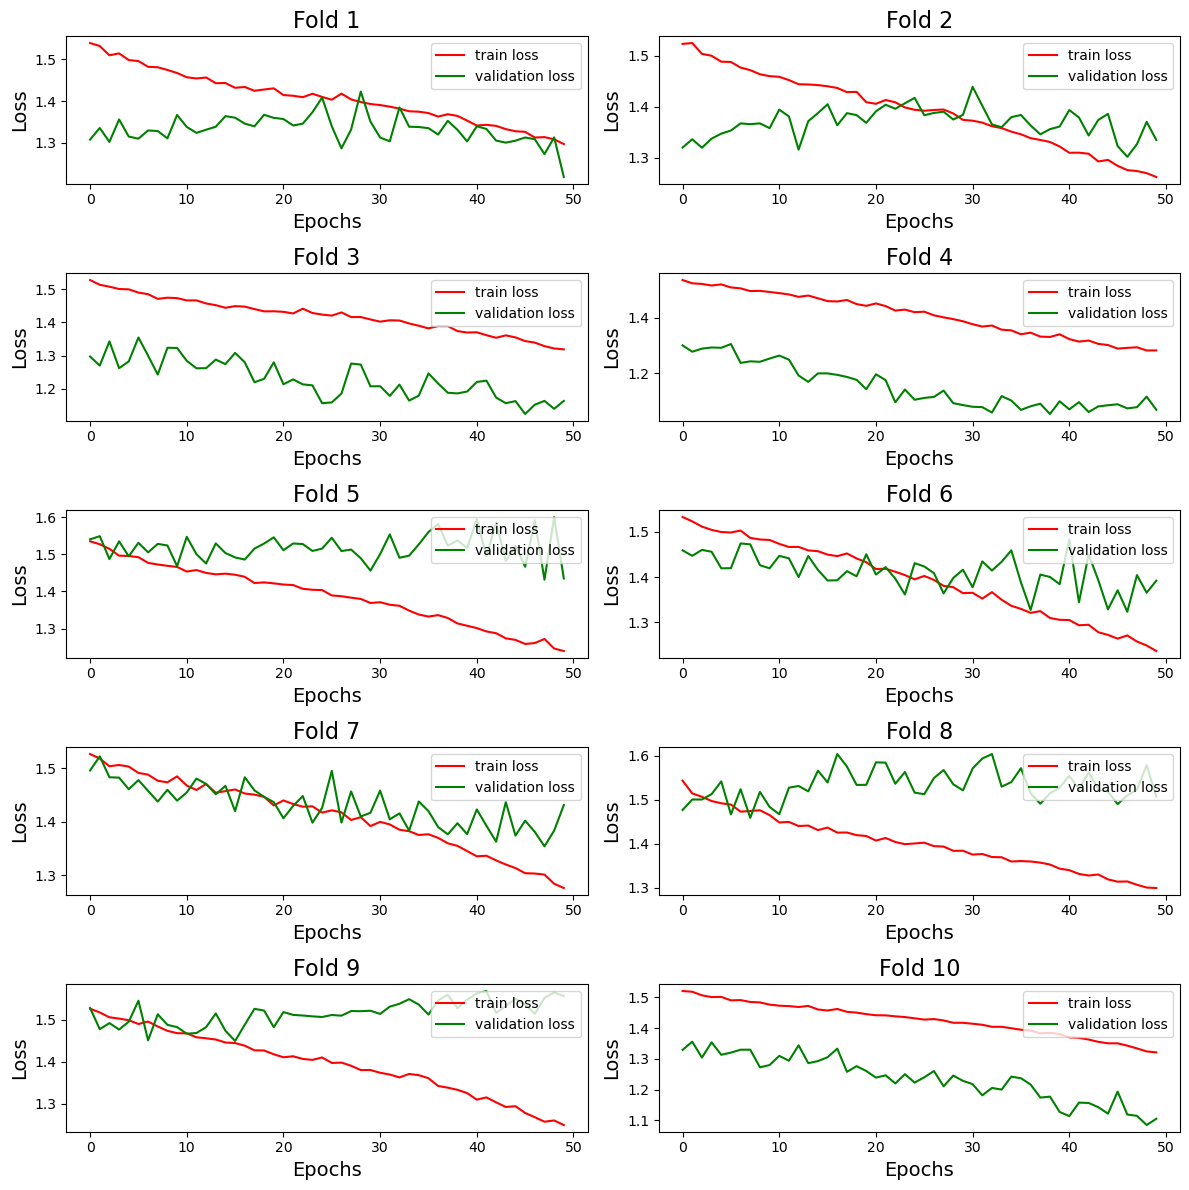

In [265]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 2, figsize=(12, 12))

for i, ax in enumerate(axs.flatten()):
    ax.plot(tL[i],'-r')
    ax.plot(vL[i],'-g')
    ax.legend(['train loss', 'validation loss'],loc ="upper right")
    ax.set_title(f'Fold {i+1}', fontsize=16)
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)

plt.tight_layout()
plt.show()

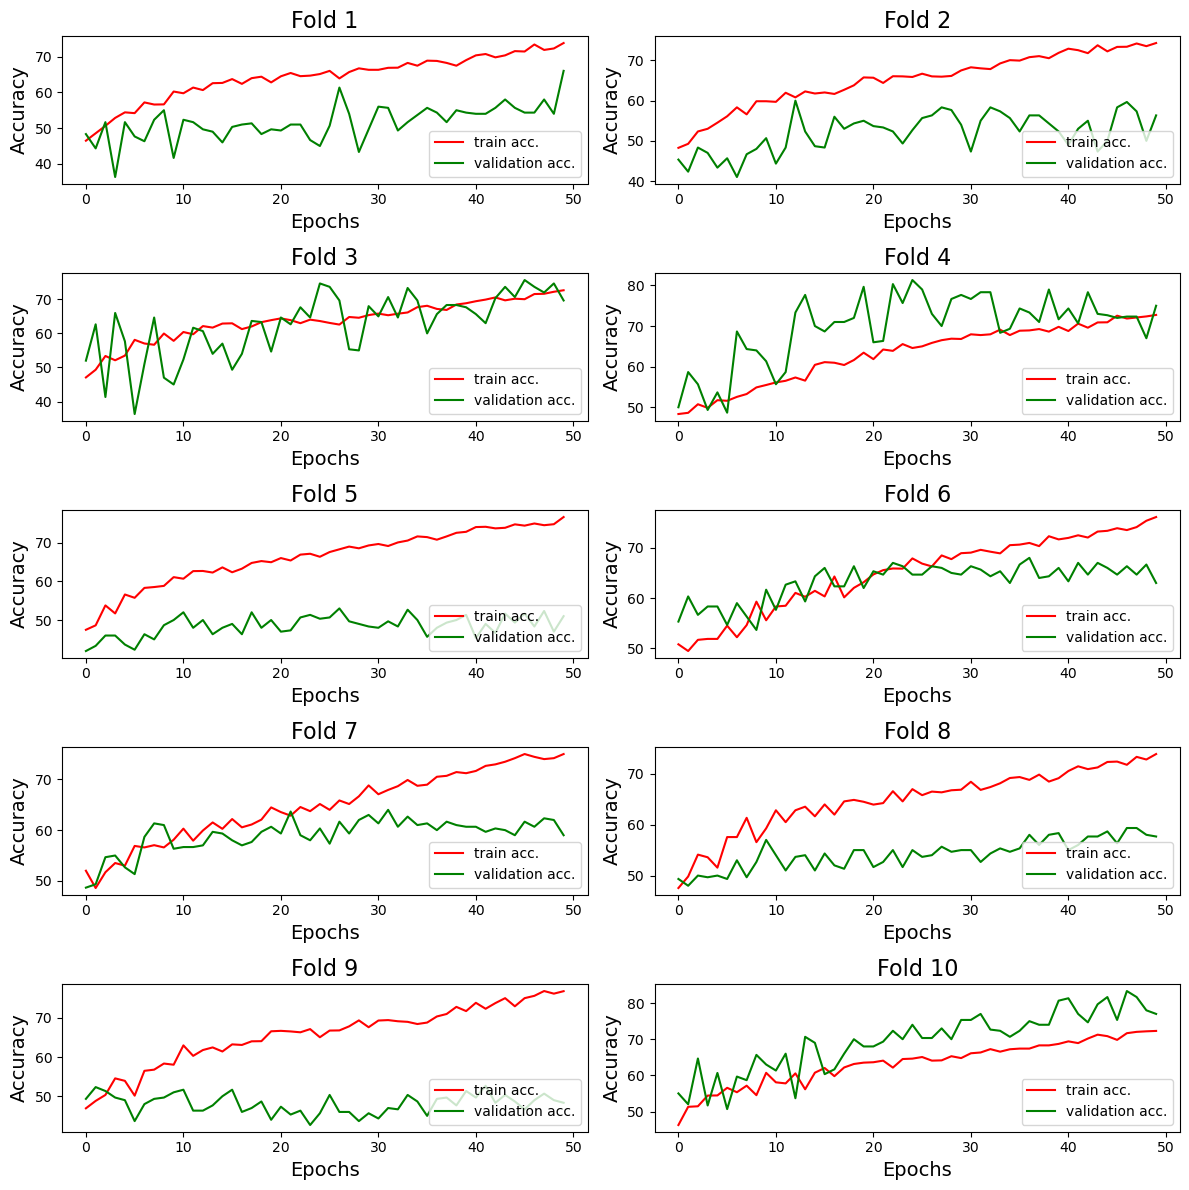

In [266]:
fig, axs = plt.subplots(5, 2, figsize=(12, 12))

for i, ax in enumerate(axs.flatten()):
    ax.plot(tAV[i],'-r')
    ax.plot(vAV[i],'-g')
    ax.legend(['train acc.', 'validation acc.'],loc ="lower right")
    ax.set_title(f'Fold {i+1}', fontsize=16)
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)

plt.tight_layout()
plt.show()

In [267]:
tr = []
pred_gt_tuple = []
for key,value in log_pred_dict.items():
    tr.append(value['trails'])
    pred = torch.cat((value['predicted']),0)
    ground_truth = torch.cat((value['ground truth']),0)
    p = pred.to('cpu').numpy()
    g = ground_truth.to('cpu').numpy()
    print(p.shape)
    print(g.shape)
    pred_gt_tuple.append([p,g])

(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(225,)
(225,)


In [268]:
log = {'trials': tr,
       'pred_gt': pred_gt_tuple}

In [269]:
scipy.io.savemat('./logs/log_Augmodel_s01_v_z.mat',log)